<a href="https://colab.research.google.com/github/CeliaDiazSanchez/Data-Mining/blob/LAB04/LAB04_EJ4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**LABORATORIO 4**
**Grupo**: B01

**Integrantes**: Claudia Esnarrizaga, Ana Robledano, Celia Díaz, Julia Callaba

## **EJERCICIO 1 (Regresión lineal simple)**

### **Enunciado**

Una prestigiosa empresa productora de vinos quiere construir un modelo de regresión que le permita predecir
el porcentaje de alcohol de un vino en base a ciertas características (acidez, azúcar residual, azufre, cloruros,
densidad, tipo de vino, sulfatos y pH).
Para ello han construido un dataset, denominado wine_alcohol.csv, que contiene la información de todos los
vinos que han sido producidos en los últimos años con el objetivo de construir un modelo y realizar las
siguientes acciones:

1. Realizar todo el proceso de preparación, limpieza y análisis de los datos con el objetivo de identificar
aquellas variables candidatas para el proceso de regresión (0.5 puntos).

2. Realizar un análisis sobre los atributos del dataset con el objetivo de entender las posibles relaciones
que existen entre ellas y a continuación elige los dos atributos que mayor relación guardan con el
atributo objetivo (nivel de alcohol) (1 punto). En necesario justificar la elección de los atributos
mediante la utilización de datos empíricos.

3. Construir un modelo de regresión lineal mediante un proceso analítico para una de las variables
seleccionadas en el punto anterior (1 punto).

4. Calcular el error en el modelo obtenidos en el punto anterior (0.5 puntos).

### **PARTE 1**

Importamos las librerías necesarias y el archivo.

In [297]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import numpy as np
import scipy.stats as stats
import requests
# URL del archivo CSV en GitHub
url = "https://raw.githubusercontent.com/CeliaDiazSanchez/Data-Mining/LAB04/wine_alcohol.csv"
nombre = 'wine_alcohol.csv'


# Realizar la solicitud GET para obtener el contenido del archivo
response = requests.get(url)

# Verificar si la solicitud fue exitosa (código de estado 200)
if response.status_code == 200:
     # Guardar el contenido del archivo en un archivo local
    with open(nombre, 'wb') as f:
        f.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo.")

Archivo descargado exitosamente.


Aparece un warning del tipo `DeprecationWarning`, lo cual significa que se está utilizando una función o característica que será eliminada en futuras versiones de Python. Este tipo de advertencia no afecta el funcionamiento del código actual, por lo que desactivamos los warnings de este tipo:

In [298]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Cargamos el archivo de cancer CSV en un DataFrame de pandas que llamamos ds.

In [299]:
ds = pd.read_csv('wine_alcohol.csv', sep = ';')
# Mostramos las 5 primeras entradas del dataset
ds.head(5)

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,wine type,alcohol
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,1,9.4
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,5,1,9.8
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,5,1,9.8
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,6,1,9.8
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,1,9.4


Creamos una copia del dataFrame original, para poder volver a este tras modificar la copia.

In [300]:
df = ds.copy()
id(df), id(ds)

(137225075789056, 137225175101744)

#### **Exploración y limpieza de la base de datos**

Se trata de una base de datos con datos sobre características de vinos.

In [301]:
ds.shape

(6497, 14)

Tiene `6497` **filas** o registros de vinos y `13` **columnas** que vamos a analizar.

Veamos si hay NaNs

In [302]:
# Verifica si hay NaNs en cada columna
nan_check = ds.isna().any()

# Muestra las columnas con NaNs, si las hay
columns_with_nans = nan_check[nan_check].index.tolist()
if columns_with_nans:
    print("Las siguientes columnas contienen NaNs:")
    print(columns_with_nans)
else:
    print("No hay NaNs en ninguna columna.")

No hay NaNs en ninguna columna.


In [303]:
columnas = ds.columns
print(columnas)

Index(['id', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'quality',
       'wine type', 'alcohol'],
      dtype='object')


Observaciones:
Claro, analicemos cada una de las columnas en relación con la variable objetivo "alcohol":

- **Fixed Acidity**: Representa la cantidad de ácidos fijos presentes en el vino. Podría haber una correlación entre el nivel de ácido fijo y el contenido de alcohol, ya que el proceso de fermentación puede influir en ambos. Vinos con niveles más altos de ácido fijo pueden tener niveles de alcohol ligeramente más bajos debido a la conversión de azúcares en ácido durante la fermentación.

- **Volatile Acidity**: Se refiere a la cantidad de ácidos volátiles en el vino, principalmente ácido acético. Altos niveles de ácido volátil pueden indicar una fermentación incorrecta o la presencia de bacterias no deseadas. Esta variable puede no tener una relación directa con el contenido de alcohol, pero su presencia puede influir en el perfil general del vino, incluido el contenido de alcohol percibido.

- **Citric Acid**: Es un ácido orgánico que se encuentra naturalmente en las frutas cítricas y también se puede agregar al vino como aditivo. La presencia de ácido cítrico puede afectar el sabor y la acidez del vino, pero no está directamente relacionada con el contenido de alcohol.

- **Residual Sugar**: Representa la cantidad de azúcar que queda en el vino después de la fermentación. Altos niveles de azúcar residual pueden indicar vinos dulces, mientras que bajos niveles de azúcar residual pueden indicar vinos secos. Esta variable puede tener una relación inversa con el contenido de alcohol, ya que el azúcar residual se convierte en alcohol durante la fermentación.

- **Chlorides**: Se refiere a la concentración de cloruros en el vino. Los cloruros pueden provenir de fuentes naturales o pueden ser agregados durante la vinificación. No hay una relación directa entre los cloruros y el contenido de alcohol, pero pueden influir en el sabor y la percepción general del vino.

- **Free Sulfur Dioxide** y **Total Sulfur Dioxide**: Representan las concentraciones de dióxido de azufre libre y total en el vino, respectivamente. El azufre se utiliza comúnmente como conservante en el vino para prevenir la oxidación y el crecimiento microbiano. No hay una relación directa entre el azufre y el contenido de alcohol, pero pueden afectar la estabilidad y la calidad del vino.

- **Density**: La densidad del vino está relacionada con su contenido de azúcar y alcohol. La densidad puede influir en el contenido de alcohol percibido y en la textura del vino, pero la relación entre la densidad y el contenido de alcohol puede ser compleja debido a la influencia de otros componentes del vino.

- **pH**: El pH del vino puede afectar su estabilidad química y microbiológica, así como su sabor y estructura. No hay una relación directa entre el pH y el contenido de alcohol, pero el pH puede influir en la percepción general del vino.

- **Sulphates**: Los sulfitos se agregan al vino como conservantes y antioxidantes. No hay una relación directa entre los sulfitos y el contenido de alcohol, pero pueden influir en la frescura y longevidad del vino.

- **Quality**: La calidad del vino es un aspecto subjetivo, pero puede estar influenciada por una combinación de factores como los mencionados anteriormente, así como por el proceso de elaboración y las preferencias individuales del consumidor. La calidad del vino puede influir en el contenido de alcohol percibido y en la preferencia del consumidor.

- **Wine Type**: Indica el tipo de vino (blanco, tinto, rosado, etc.). El tipo de vino puede influir en el perfil general del vino, incluido el contenido de alcohol percibido y las preferencias del consumidor.

- **Alcohol**: Esta es la variable objetivo que queremos predecir. Representa el porcentaje de alcohol en volumen en el vino. El contenido de alcohol puede estar influenciado por una variedad de factores, incluidos los mencionados anteriormente, así como por el proceso de fermentación y las prácticas de vinificación.

Cada variable es del siguiente tipo:

In [304]:
ds.dtypes

id                        int64
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
quality                   int64
wine type                 int64
alcohol                 float64
dtype: object

Teniendo en cuenta estos casos, vamos a modificar algunas variables y representar sus dominios para la detección de outliers.

Convertimos la columna de `id` a índice del DataFrame.

In [305]:
ds.set_index(columnas[0], inplace=True)

Convertimos a tipo de variable categórica `wine type` y `quality`

In [306]:
ds['quality'] = ds['quality'].astype('category')
ds['wine type'] = ds['wine type'].astype('category')

Veamos que valores toman y cómo se distribuyen:

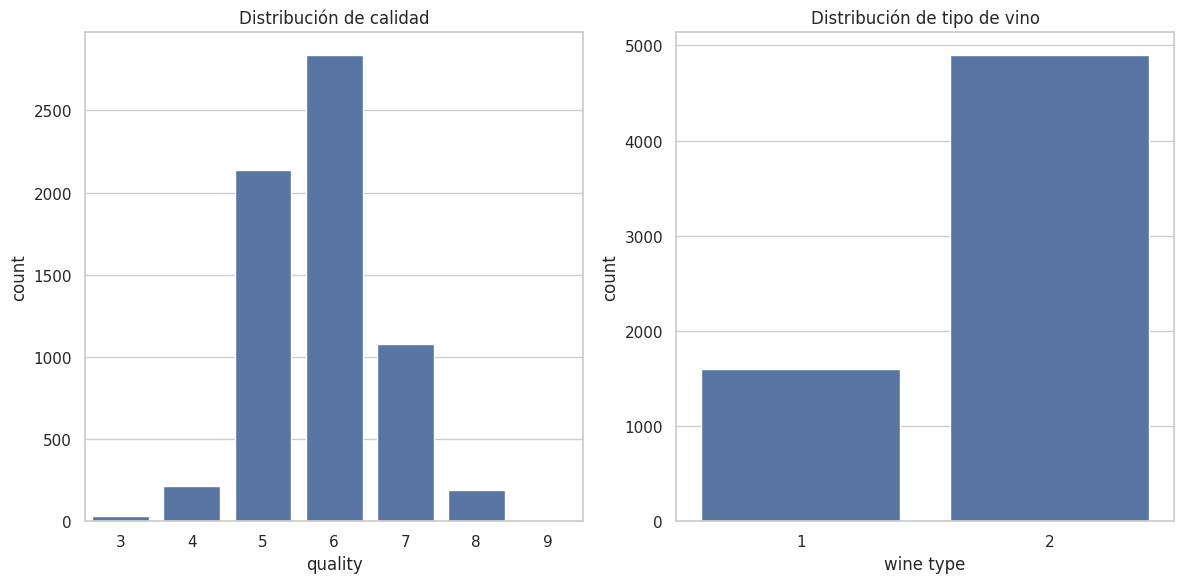

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Graficar la distribución de 'quality'
sns.countplot(data=ds, x='quality', ax=axes[0])
axes[0].set_title('Distribución de calidad')

# Graficar la distribución de 'wine type'
sns.countplot(data=ds, x='wine type', ax=axes[1])
axes[1].set_title('Distribución de tipo de vino')

# Ajustar el diseño para evitar la superposición de etiquetas
plt.tight_layout()

# Mostrar los subplots
plt.show()


El vino se divide en 2 tipos: `1 y 2`, con la mayoría de muestras pertenecientes al tipo `2`.

La mayoría de vinos son de calidad 6, y hay muy pocos de calidad 3 y 9. Aunque no está especificado en la base de datos, interpretamos que la peor calidad es 3 y la mejor 9. Para mayor eficiencia en los modelos de clasificación, agrupamos las calidades `3-4` y `8-9` ya que por separado engloban una cantidad de registros proporcionalmente despreciables.

In [308]:
# Reemplazar los valores 3 y 4 con un nuevo valor 4
ds['quality'] = ds['quality'].replace({3: 4})

# Reemplazar los valores 8 y 9 con un nuevo valor 8
ds['quality'] = ds['quality'].replace({9: 8})

Mostramos una descripción de los valores que toman las variables para contrastar las observaciones.

In [309]:
ds.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


Para mayor claridad visual, representamos los valores de las variables mediante boxplots.


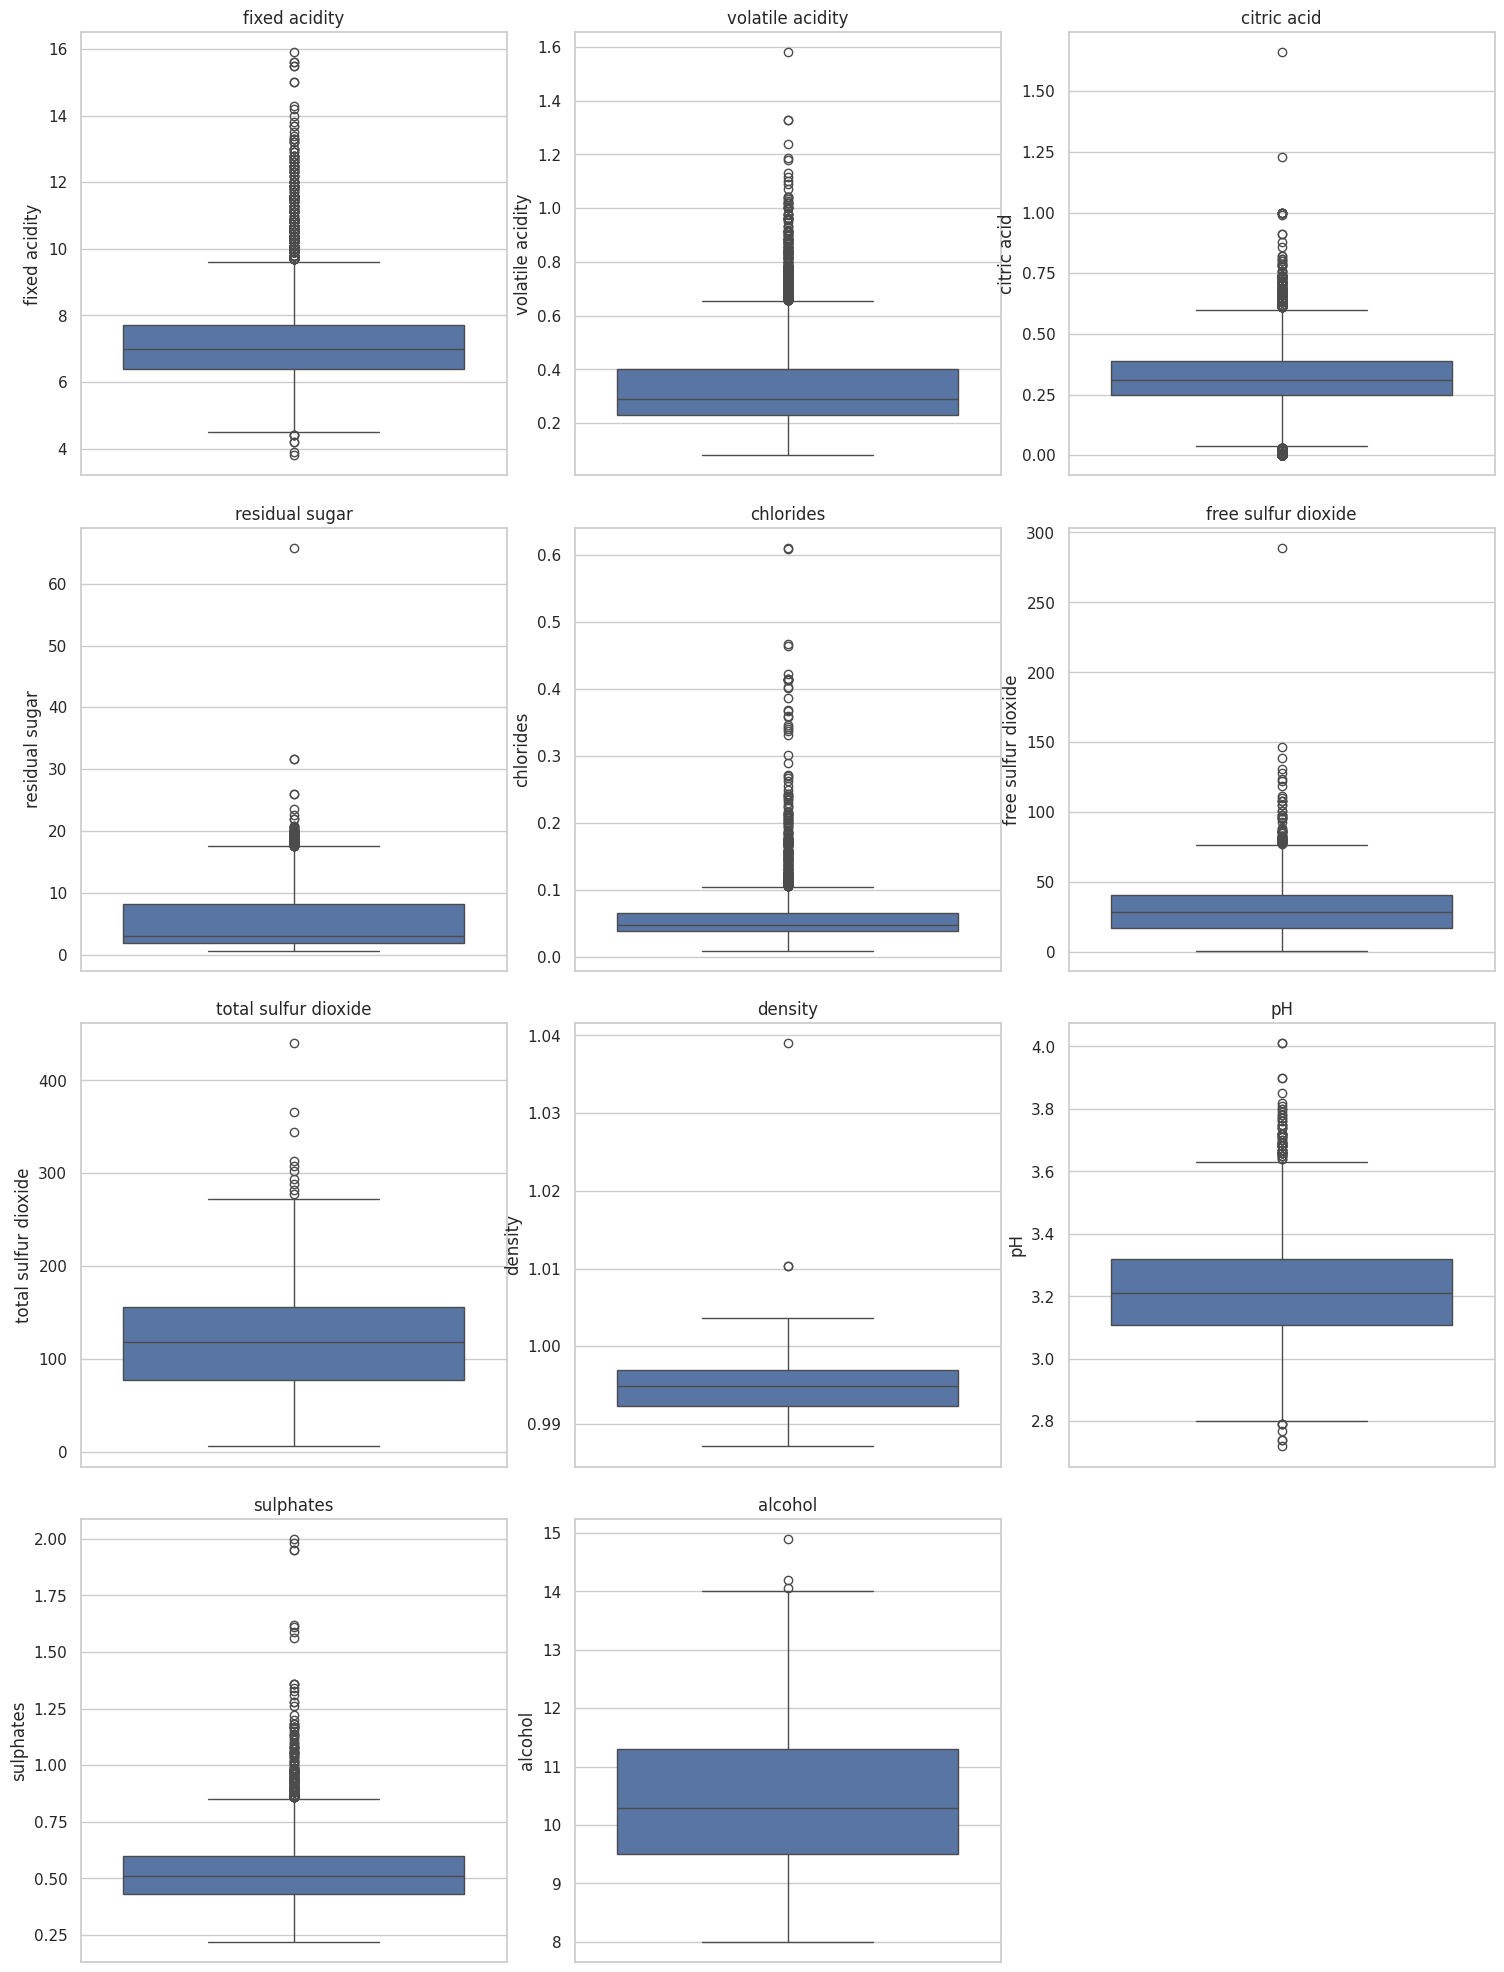

In [310]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración opcional para mejorar el aspecto de los gráficos
sns.set(style="whitegrid")

# Seleccionar solo las columnas numéricas
columnas = ds.select_dtypes(include=['int', 'float']).columns

# Obtener el número de columnas en el dataframe
num_cols = len(columnas)

# Calcular el número de filas y columnas para los subplots
num_rows = (num_cols // 3) + (num_cols % 3 > 0)
num_cols_subplot = min(num_cols, 3)

# Crear subplots
fig, axes = plt.subplots(num_rows, num_cols_subplot, figsize=(15, 5 * num_rows))

# Ajustar el diseño para evitar la superposición de etiquetas
plt.tight_layout()

# Crear boxplots para cada columna en el dataframe
for i, col in enumerate(columnas):
      row_idx = i // num_cols_subplot
      col_idx = i % num_cols_subplot
      ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
      sns.boxplot(data=ds[col], ax=ax)
      ax.set_title(col)

# Eliminar subplots no utilizados
for i in range(num_cols, num_rows * num_cols_subplot):
    row_idx = i // num_cols_subplot
    col_idx = i % num_cols_subplot
    ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
    fig.delaxes(ax)

# Mostrar los subplots
plt.show()


El pH de los vinos oscila entre 2.8 y 4, por lo que eliminamos las observaciones que se salen de ese rango:

In [311]:
# Filtrar las observaciones
ds = ds[(ds['pH'] <= 4) & (ds['pH'] >= 2.8)]

Además la densidad máxima del vino es de 1'0008g/L

In [312]:
ds = ds[(ds['density'] <= 1.008)]

Observamos una gran cantidad de outliers para algunas variables como `sulphates` o `fixed acidity`

Según ChatGPT:
> "El rango de valores que puede tomar "fixed acidity" en un vino puede variar dependiendo del tipo de vino y de la fuente de la información. Por lo general, el rango puede ser bastante amplio, ya que diferentes vinos tienen diferentes niveles de acidez. En general, para vinos blancos, el nivel de acidez (expresado como "fixed acidity" en la etiqueta) puede variar aproximadamente entre 4 y 8 gramos por litro (g/L). Para vinos tintos, el rango puede ser un poco más alto, normalmente entre 5 y 9 g/L. Estos son solo rangos aproximados y pueden variar según la variedad de uva, la región vinícola y el estilo del vino."

Como no somos expertos en vino, no vamos a descartar totalmente todos los outliers, no obstante si eliminaremos de cada variable la observación (si la hay) que se encuentra desproporcionadamente alejada de todas las demás. Esto sucede para los valores máximos de: `volatile acidity, citric acid, residual sugar, chlorides, free sulfure dioxide, total sulfure dioxide y density.`

In [313]:
# Obtener los valores máximos de las variables mencionadas
max_values = ds[['volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
                 'free sulfur dioxide', 'total sulfur dioxide']].max()

# Filtrar las observaciones que contienen los valores máximos
condiciones = ((ds['volatile acidity'] != max_values['volatile acidity']) &
               (ds['citric acid'] != max_values['citric acid']) &
               (ds['residual sugar'] != max_values['residual sugar']) &
               (ds['chlorides'] != max_values['chlorides']) &
               (ds['free sulfur dioxide'] != max_values['free sulfur dioxide']) &
               (ds['total sulfur dioxide'] != max_values['total sulfur dioxide']))

# Crear un nuevo DataFrame sin las observaciones que contienen los valores máximos
df = ds[condiciones].copy()

# Verificar el nuevo DataFrame
df.head(3)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,wine type,alcohol
id,,,,,,,,,,,,,
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,1,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,5,1,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,5,1,9.8


### **PARTE 2**

Para identificar las variables candidatas para el proceso de regresión, hagamos la matriz de correlación para ver cómo están relacionadas entre ellas las variables.

In [314]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

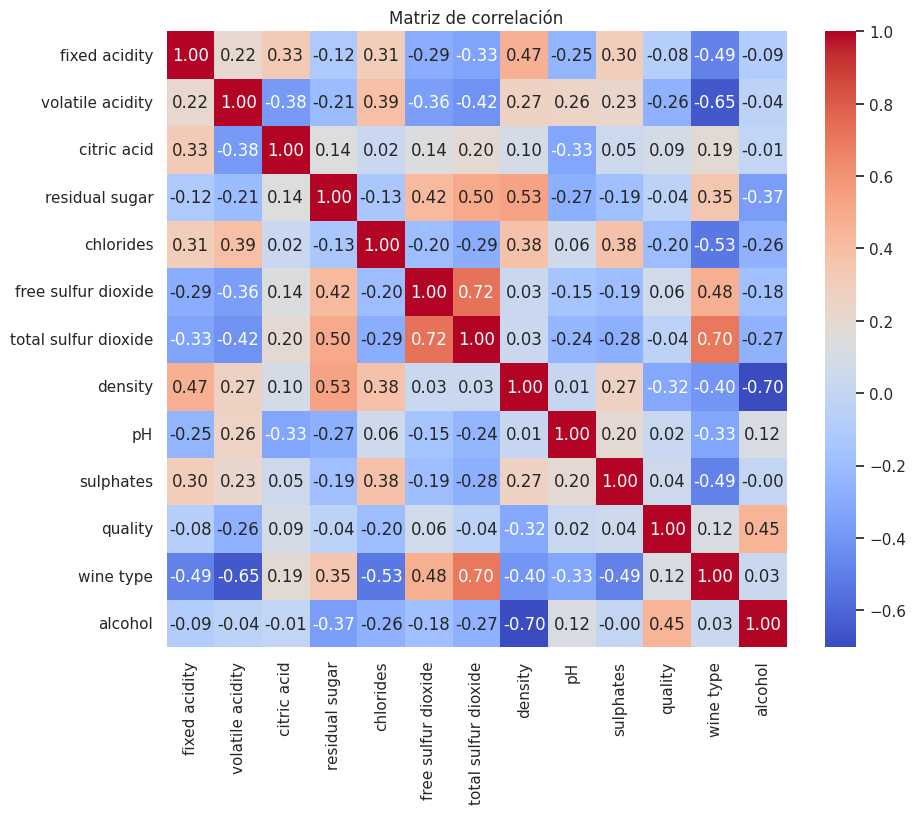

In [315]:
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Generar el mapa de calor utilizando Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Matriz de correlación')

# Mostrar el gráfico
plt.show()

Observamos que algunas variables están altamente correlacionadas entre ellas, estas variables generan ruido en los modelos de clasificación al no aportar información nueva sobre la variable objetivo.
- `total sulfur dioxide` - `free sulfure dioxide`
- `wine type` - `total sulfure dioxide`
- `wine type` - `volatile acidity`

Observamos que el total de dióxido sulfúrico está directamente relacionado con el nivel libre de ácido sulfúrico, además el total tiene otra relación directa con el tipo de vino. Como es más fácil de identificar el tipo de vino, vamos a conservar esa variable y eliminar aquellas que tienen un nivel alto de correlación con ella. Por otra parte `fixed acidity` presenta correlaciones ligeramente altas con muchas variables como `wine type` y `density` por lo que la eliminaremos.

In [316]:
df.drop(columns= ['total sulfur dioxide'],inplace=True)

In [317]:
df.drop(columns= ['volatile acidity'],inplace=True)

In [318]:
df.drop(columns= ['fixed acidity'],inplace=True)

Calculamos de nuevo la matriz de correlación para asegurarnos de que no haya quedado ninguna variable con correlaciones altas (sin contar con la objetivo que la analizaremos más tarde).

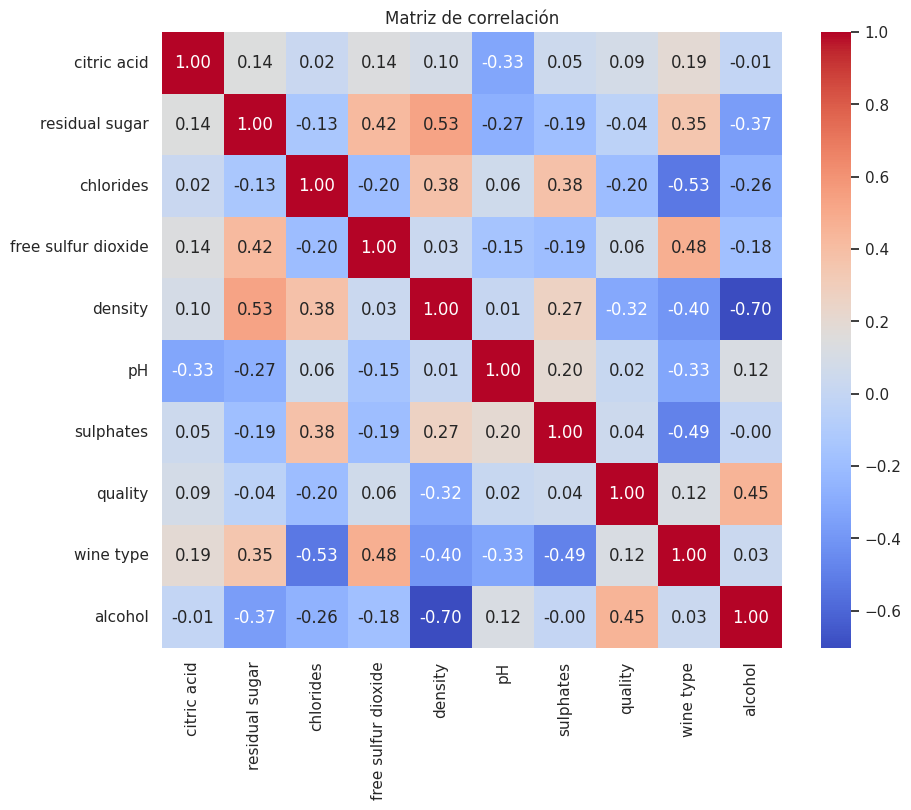

In [319]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Generar el mapa de calor utilizando Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Matriz de correlación')

# Mostrar el gráfico
plt.show()

Vamos  calcular la correlación entre el nivel de alcohol y cada una de las otras variables en el conjunto de datos, excluyendo la columna del identificador 'id' y la propia columna de 'alcohol'.

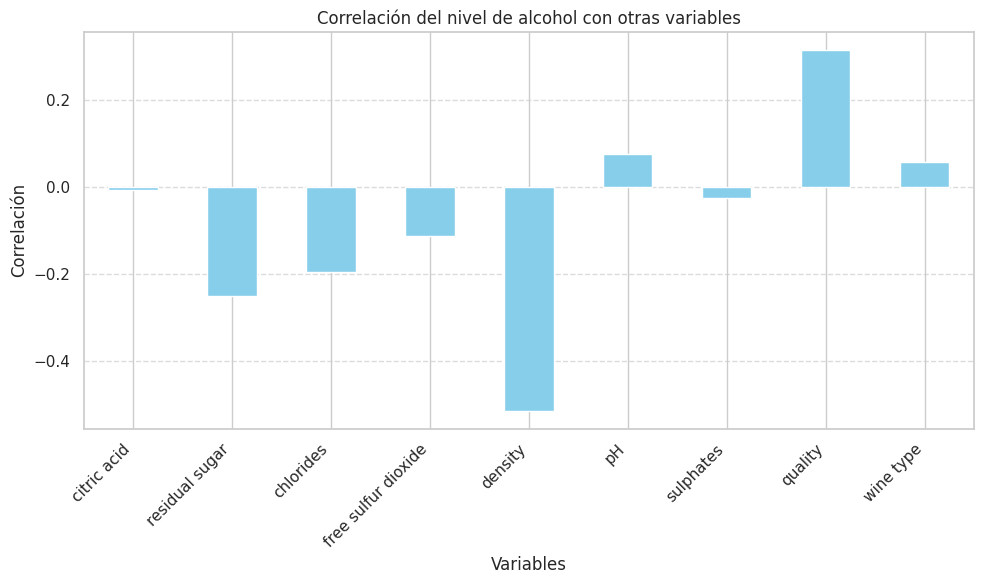

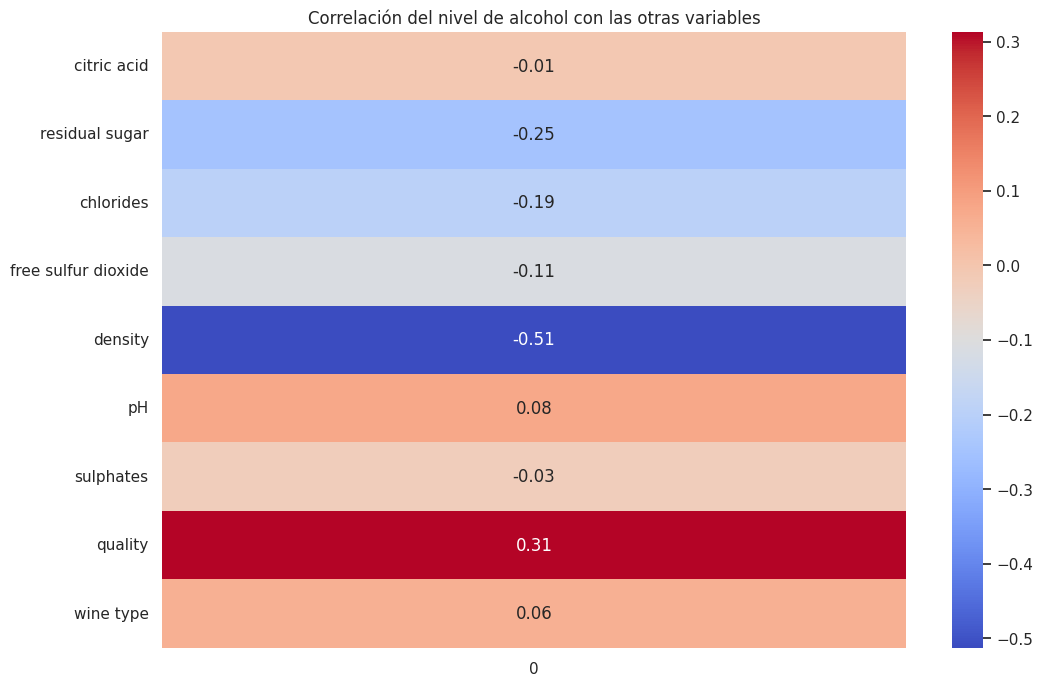

In [320]:
# Calcula la matriz de correlación
alcohol_corr = df.drop(columns=['alcohol']).corrwith(ds['alcohol'])

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Generar el gráfico de barras para visualizar la matriz de correlación
alcohol_corr.plot(kind='bar', color='skyblue')
plt.title('Correlación del nivel de alcohol con otras variables')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Configurar el tamaño de la figura para el mapa de calor
plt.figure(figsize=(12, 8))

# Generar el mapa de calor utilizando Seaborn
sns.heatmap(alcohol_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Correlación del nivel de alcohol con las otras variables')

# Mostrar el gráfico
plt.show()


Podemos observar que las variables que más relación tienen con el nivel de alcohol son `density` y `quality`.



La conclusión de que las variables "density" (densidad) y "quality" (calidad) tienen una mayor correlación con el nivel de alcohol en el vino es bastante interesante y puede ofrecer algunas ideas importantes sobre la relación entre estas variables.

1. **Density (-0.69)**:
   - La densidad del vino está relacionada con su contenido de azúcar y alcohol. Una mayor densidad puede indicar una mayor concentración de azúcares y alcohol en el vino.
   - En general, a medida que aumenta el contenido de alcohol en el vino, su densidad tiende a disminuir. Esto se debe a que el alcohol tiene una densidad menor que el agua y otros componentes del vino.
   - Por lo tanto, la correlación negativa entre la densidad y el nivel de alcohol es esperada y sugiere que la densidad puede ser un indicador indirecto del contenido de alcohol en el vino.

2. **Quality (0.44)**:
   - La calidad del vino es un aspecto subjetivo que puede estar influenciado por una variedad de factores, incluido el contenido de alcohol.
   - Es común que vinos de mayor calidad tengan un mayor contenido de alcohol, especialmente en el caso de vinos finos y de alta gama. Esto se debe a que el proceso de vinificación y maduración puede llevar a un mayor desarrollo de sabores y aromas, que a menudo se asocian con vinos con un contenido de alcohol más alto.
   - La correlación positiva entre la calidad y el nivel de alcohol sugiere que, en general, los vinos de mayor calidad tienden a tener un mayor contenido de alcohol. Esto puede ser una indicación de que el contenido de alcohol contribuye a la percepción general de calidad en el vino.

### **PARTE 3**

Para este apartado, tenemos que construir un modelo de regresión lineal mediante un proceso analítico para una de las variables seleccionadas en el punto anterior. Para ello, seguiremos el siguiente procedimiento:

1. Dividir los datos en conjuntos de entrenamiento y prueba.
2. Ajustar un modelo de regresión lineal para cada variable seleccionada.
3. Evaluar el rendimiento del modelo utilizando métricas como el error cuadrático medio (MSE) o el coeficiente de determinación (R²).

**Density**

In [321]:
# Seleccionamos las variables predictoras
X_density = df[['density']]

# Seleccionamos la variable objetivo
y = df['alcohol']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_density_train, X_density_test, y_train, y_test = train_test_split(X_density, y, test_size=0.2, random_state=42)

Creamos y ajustamos el modelo de regresión lineal para la variable **density**

In [322]:
model_density = LinearRegression()
model_density.fit(X_density_train, y_train)

LinearRegression()

Predecimos los valores de la variable objetivo en el conjunto de prueba


In [323]:
y_pred_density = model_density.predict(X_density_test)

**Interpretación de resultados:**

Al hacer una regresión lineal con una sola variable, estamos calculando lo siguiente:

$$ y = \beta_{0} + \beta_{1} \cdot\ x_{1} $$

Con:
- $y = $ variable objetivo `alcohol`
- $\beta_{0} = $ intercepto
- $\beta_{1} = $ coeficiente de la variable predictora `density`
- $x_{1} = $ variable predictora `density`

In [324]:
print("El intercepto b0 es: ", model_density.intercept_)
print("El coeficiente b1 es: ", model_density.coef_)

El intercepto b0 es:  297.44857474277853
El coeficiente b1 es:  [-288.5004115]


- El intercepto se encuentra en `292`, es decir, cuando la densidad es cero, el grado de alcohol es `292`. No obstante, que la densidad sea 0 es surrealista.
- El coeficiente que acompaña a la variable de densidad, es `-287`, lo que indica una relación inversa entre la densidad y el grado de alcohol. En concreto, por cada unidad que aumenta la densidad, el grado de alcohol disminuye en `-287`. Aunque parezca una variación muy grande, hay que tener en cuenta que la densidad se encuentra en un rango muy pequeño de valores, entre 0.99 y 1.01, por lo que el alcohol no varía tanto.

**Representación gráfica**


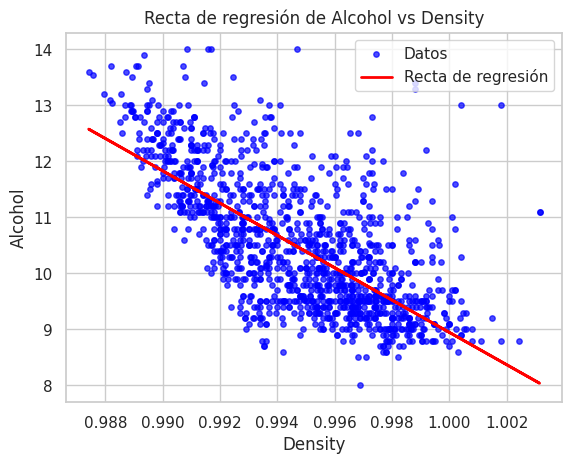

In [325]:
# Graficar los puntos de datos
plt.scatter(X_density_test, y_test, color='blue', label='Datos',s=15,alpha = 0.7)

# Graficar la recta de regresión
plt.plot(X_density_test, y_pred_density, color='red', linewidth=2, label='Recta de regresión')

# Etiquetas y leyenda
plt.xlabel('Density')
plt.ylabel('Alcohol')
plt.title('Recta de regresión de Alcohol vs Density')
plt.legend()

# Mostrar la gráfica
plt.show()


- Los puntos azules son las observaciones, es decir cada registro de vino del dataset.
- La recta roja es la recta de regresión calculada que mejor se ajusta a los puntos.

Observamos que la gran cantidad de datos genera ruido, haciendo difícil la obtención de una recta que se ajuste a ellos. Por otra parte, algunas observaciones se salen totalmente del espectro de puntos por el que puede pasar una recta.

De acuerdo al coeficiente beta 1 (-283) y a la correlación de `density` con `alcohol` calculada anteriormente (-0.69). Observamos que en la gráfica observamos que a mayor densidad, menor grado de alcohol tiene el vino (relación inversa). Aunque esto no se cumple para todas las observaciones, ya que algunos puntos se encuentran dispersos, por ejemplo un vino toma valor 14 para la variable alcohol, teniendo una densidad superior a otros vinos con menor grado de alcohol. Esto indica que un modelo de regresión lineal con esta variable podría no ser adecuado o que hay un sesgo en los datos.

**Quality**

Vamos a mejorar el modelo anterior, empleando la variable `quality` como segunda variable predictora. La elegimos porque es la segunda variable con mayor correlación con la objetivo.

In [326]:
df['quality'].unique()

[5, 6, 7, 4, 8]
Categories (5, int64): [4, 5, 6, 7, 8]

Como la calidad del vino `quality` es una variable categórica con 7 niveles, la ecuación de la recta será la siguiente:


$$
y = \beta_0 + \beta_{1} \cdot\ x_{1} + \gamma_3 \text{Q}_3 + \gamma_4 \text{Q}_4 + \gamma_5 \text{Q}_5 + \gamma_6 \text{Q}_6 + \gamma_7 \text{Q}_7
$$

Se han añadido:
- $\gamma_{i} = $ coeficientes binarios de la variable predictora `quality`, uno de ellos toma el valor 1 para indicar cuál es el nivel de calidad y los demás 0.
- $\text{Q}_{i} = $ variables dummy, cada una corresponde a un nivel de la variable categórica original `quality`.

Se puede eliminar un nivel, ya que si $\gamma_{i} = 0 $ para todo $i$, entonces se trata de un vino con `quality = 8`.

Utilizamos la función `get_dummies` de pandas para obtener dicho formato.

In [327]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df[['density', 'quality']]

# Convertir la variable categórica 'quality' en variables dummy utilizando one-hot encoding
X = pd.get_dummies(X, columns=['quality'], drop_first=True) # la primera dummy se elimina

# Seleccionar la variable objetivo
y = df['alcohol']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y ajustar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir los valores de la variable objetivo en el conjunto de prueba
y_pred = model.predict(X_test)


Tenemos la variable `density` y 4 variables dummy de `quality` para predecir `alcohol`

In [328]:
X.head(3)

,density,quality_5,quality_6,quality_7,quality_8
id,,,,,
0,0.9978,True,False,False,False
1,0.9968,True,False,False,False
2,0.9970,True,False,False,False


En `y` están las etiquetas del grado de alcohol que buscamos predecir.

In [329]:
y.head(3)

id
0    9.4
1    9.8
2    9.8
Name: alcohol, dtype: float64

**Interpretación de resultados**


In [330]:
print("El intercepto b0 es: ", model.intercept_)
print("Los coeficientes son:  ", model.coef_)

El intercepto b0 es:  260.4317884061063
Los coeficientes son:   [-2.51551793e+02 -1.00353245e-01  3.28533920e-01  7.72325999e-01
  9.02166521e-01]


Que los coeficientes sean ceranos a cero indica que la variable no es significativa para la predicción.

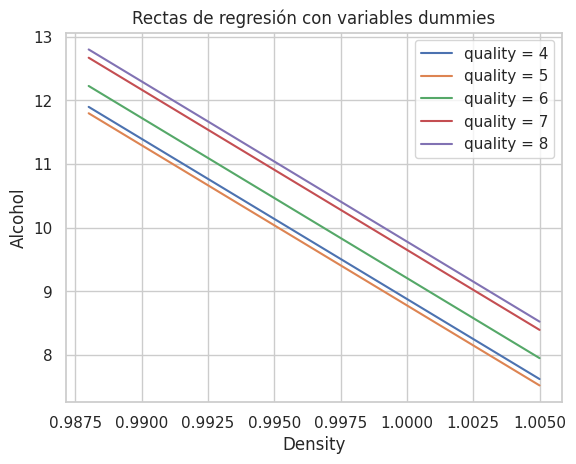

In [331]:
import numpy as np
import matplotlib.pyplot as plt

# Definir los valores de density (acordes a su dominio)
x = np.linspace(0.988, 1.005, 100)

# Definir el intercepto y los coeficientes
b0 = model.intercept_
b1 = model.coef_[0]
gamma_values = model.coef_[1:] # coeficientes de las variables dummy


# cuando quality = 3, todas las gamma_i = 0
y = b0 + b1 * x
# Graficar la recta
plt.plot(x, y, label=f'quality = 4')

# Graficar las rectas para cada coeficiente b1
for i, gamma_i in enumerate(gamma_values):
    # Calcular los valores y utilizando la ecuación de la recta
    y = b0 + b1 * x + gamma_i

    # Graficar la recta
    plt.plot(x, y, label=f'quality = {i+5}')

# Etiquetas y leyenda
plt.xlabel('Density')
plt.ylabel('Alcohol')
plt.title('Rectas de regresión con variables dummies')
plt.legend()

# Mostrar la gráfica
plt.show()


Ahora hemos obtenido distintas rectas, para cada categoría de la calidad de un vino. Es decir, cuando se introduzca un vino definido por su densidad y calidad, el modelo predecirá el grado de alcohol teniendo en cuenta los niveles de calidad con las variables dummies en la ecuación de la recta.

Observamos que, a mayor calidad, mayor es el grado de alcohol (una relación directa ya observada en la correlación). Hay una pequeña variación en `quality=5` ya que tiene ligeramente un menor grado de alcohol que `quality=4`.

### **PARTE 4**

Para calcular el error en el modelo obtenidos en el punto anterior, haremos uso del $ R^2 $ y el error cuadrático medio ($ MSE $).

$
R^2 = 1 - \frac{{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}}{{\sum_{i=1}^{n} (y_i - \bar{y})^2}}
$

Donde:
- $ n $ es el número de observaciones.
- $ y_i $ son los valores reales de la variable objetivo.
- $ \hat{y}_i $ son las predicciones del modelo para la variable objetivo.
- $ \bar{y} $ es la media de los valores reales de la variable objetivo.

Esta fórmula calcula el porcentaje de variabilidad en la variable objetivo que es explicada por el modelo de regresión.

$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$

Donde:
- $ n $ es el número de observaciones.
- $ y_i $ son los valores reales de la variable objetivo.
- $ \hat{y}_i $ son las predicciones del modelo para la variable objetivo.

Esta fórmula calcula el promedio de los cuadrados de las diferencias entre los valores reales y las predicciones del modelo.

Para ello, primero calcularemos el rendimiento de cada variable en nuestro modelo.

In [332]:
# density
mse_density = mean_squared_error(y_test, y_pred_density)
r2_density = r2_score(y_test, y_pred_density)

In [333]:
# density + quality
mse_quality = mean_squared_error(y_test, y_pred)
r2_quality = r2_score(y_test, y_pred)

Mostremos los resultados.

In [334]:
print("Resultados para la variable 'density':")
print("MSE:", mse_density)
print("R²:", r2_density)
print()
print("Resultados para las variables 'density' y 'quality':")
print("MSE:", mse_quality)
print("R²:", r2_quality)

Resultados para la variable 'density':
MSE: 0.7772665149905532
R²: 0.45390937514344465

Resultados para las variables 'density' y 'quality':
MSE: 0.6872215663928365
R²: 0.5171730064675101


1. **Para la variable 'density':**
   - El MSE (error cuadrático medio) es mayor que 0.7. Este valor indica el promedio de los cuadrados de los errores entre las predicciones del modelo y los valores reales de la variable objetivo. Un MSE más bajo indica un mejor ajuste del modelo a los datos.
   - El coeficiente de determinación (R²) es menor que 0.5. Este valor representa la proporción de la varianza en la variable objetivo que es explicada por el modelo. En este caso, el modelo explica aproximadamente el 48.79% de la variabilidad en el nivel de alcohol. Un valor más alto de R² indica un mejor ajuste del modelo a los datos.

2. **Para la variable 'quality':**
   - El MSE es 0.68. Este valor es más bajo que el MSE para la variable 'density', lo que sugiere que el modelo tiene un ajuste relativamente mejor para predecir el nivel de alcohol utilizando las variables 'density' y 'quality'.
   - El coeficiente de determinación (R²) es 0.51. Este valor es más alto que el R² para la variable 'density', lo que indica que el modelo explica más variabilidad en el nivel de alcohol cuando se utiliza la variable 'quality'.

En conclusión, estos resultados nos sugieren que la variable 'density' tiene un débil desempeño como variable predictora del nivel de alcohol, pero se puede mejorar añadiendo al modelo la variable 'quality' como variable categórica. Como es de esperar, al añadir variables significativas al modelo, mejora su fiabilidad en la clasificación. No utilizamos la variable 'quality' como única variable predictora ya que la calidad del vino es una medida más subjetiva y puede estar influenciada por otros factores.

Realicemos una escala para ver en tipo porcentaje nuestro error cuadrático medio.

In [335]:
# Varianza de la variable objetivo
var_objetivo = y_test.var()

# Calcular el MSE relativo en porcentaje para la variable 'density'
mse_relativo_density = (mse_density / var_objetivo) * 100

# Calcular el MSE relativo en porcentaje para la variable 'quality'
mse_relativo_quality = (mse_quality / var_objetivo) * 100

print("MSE relativo para la variable 'density': {:.2f}%".format(mse_relativo_density))
print("MSE relativo para las variables 'density' y 'quality': {:.2f}%".format(mse_relativo_quality))


MSE relativo para la variable 'density': 54.57%
MSE relativo para las variables 'density' y 'quality': 48.25%


El MSE relativo en porcentaje para cada variable ('density' y 'quality') nos proporciona una medida de cuánto representa el error cuadrático medio en relación con la variabilidad total de la variable objetivo (en este caso, el nivel de alcohol). Cuanto mayor sea el MSE relativo, mayor será el porcentaje de variabilidad en el nivel de alcohol que no se explica correctamente por el modelo.

- **MSE relativo para la variable 'density': 54.17%**:
  Esto significa que el error cuadrático medio para el modelo de regresión lineal utilizando la variable 'density' representa aproximadamente el 51.17% de la variabilidad total en el nivel de alcohol. En otras palabras, el modelo es capaz de explicar alrededor del 48.83% de la variabilidad en el nivel de alcohol, ya que la suma del MSE relativo y el porcentaje explicado por el modelo suma al 100%.

- **MSE relativo para la variable 'quality': 48.28%**:
  En este caso, el error cuadrático medio para el modelo de regresión lineal utilizando la variable 'quality' representa aproximadamente el 45.28% de la variabilidad total en el nivel de alcohol. Esto indica que el modelo es más efectivo al explicar la variabilidad en el nivel de alcohol cuando se utiliza la variable 'quality' también, ya que el MSE relativo es más bajo en comparación con el modelo que utiliza la variable 'density'.

Entonces, cuanto menor sea el MSE relativo, mejor será el rendimiento del modelo, ya que el error del modelo representa una menor proporción de la variabilidad total en la variable objetivo.

En este caso, el modelo que utiliza las variables 'density' y 'quality' tiene un rendimiento relativamente mejor en comparación con el modelo que utiliza la variable 'density'. No obstante, si se busca un modelo menos costoso computacionalmente y con menos variables, la diferencia podría no ser lo suficientemente buena como para usar el modelo con 2 variables.

## **EJERCICIO 2 (Regresión lineal múltiple)**

### **Enunciado**

La empresa productora de vinos cree que es posible construir un modelo de mejor calidad que pueda predecir
mejor el grado de alcohol de los futuros vinos si se utilizan varios atributos del dataset. Para ello se solicita la
creación de nuevos modelos realizando las siguientes acciones:
1. Crear los diferentes conjuntos de entrenamiento y test para el dataset (0.25 puntos).
2. Construir un modelo de regresión que utilice al menos 4 de los atributos (es posible utilizar más
atributos) disponibles en el dataset mediante la utilización de un proceso aprendizaje iterativo. (1.5
puntos).
3. Calcular el error del modelo (0.5 puntos).
4. Evaluar el modelo anterior con el conjunto de test construido anteriormente y explicar el resultado
obtenido. (0.25 puntos).
5. Calcular los intervalos de confianza para cada uno de los coeficientes de regresión con un intervalo de
confianza del 75% y explica el resultado obtenido (0.5 puntos).

### **PARTE 1**

Para este modelo, utilizaremos todas las variables y mediante el algoritmo RFE (Recursive Feature Elimination) se determina las variables que mejor desempeño tienen en el modelo de predicción.

In [336]:
# Seleccionar las variables predictoras y la variable objetivo
X = ds.drop(columns = ['alcohol'])
y = ds['alcohol']

# Convertir la variable categórica 'quality' en variables dummy utilizando one-hot encoding
X = pd.get_dummies(X, columns=['quality'], drop_first=True) # la primera dummy se elimina
X = pd.get_dummies(X, columns=['wine type'], drop_first=True) # la primera dummy se elimina

Hemos seleccionado todas las variables del dataFrame, y las categóricas las hemos dividido en variables dummy, una para cada nivel.

In [337]:
X.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality_5,quality_6,quality_7,quality_8,wine type_2
id,,,,,,,,,,,,,,,
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,True,False,False,False,False


Predeciremos el grado de alcohol, que para la primera observación sería `9.4g/L`

In [338]:
y.head(1)

id
0    9.4
Name: alcohol, dtype: float64

Dividimos los datos en `train` y `test` para poder probar la eficiencia del modelo.

In [339]:
# Crear conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **PARTE 2**

Creamos el modelo de regresión que utiliza todas las variables.


In [340]:
# Definir el modelo de regresión
model = LinearRegression()

Recordamos que en total hay 15 columnas, teniendo en cuenta las variables dummies que son 5 para la calidad del vino y 1 para el tipo de vino.

In [341]:
X.columns.size

15

Utilizamos un selector de características RFE que evalúa la importancia de las características en el modelo. En este caso, estamos configurándolo para elegir las 9 características más relevantes ya que con ello obtenemos la mejor precisión. El paso o `step` de 1 significa que en cada paso, el selector elimina una característica menos importante. Y así se reduce gradualmente el conjunto de características.


In [342]:
# Definir el selector de características con eliminación hacia atrás (RFE)
selector = RFE(model, n_features_to_select=9, step= 1)

# Entrenar el selector de características con todas las variables disponibles
selector = selector.fit(X_train, y_train)

# Obtener las variables seleccionadas
selected_features = X_train.columns[selector.support_]

In [343]:
# Mostrar las variables seleccionadas y el error del modelo
print("Variables seleccionadas:")
for feature in selected_features:
    print(feature)

Variables seleccionadas:
fixed acidity
volatile acidity
citric acid
residual sugar
chlorides
density
pH
sulphates
wine type_2


- **Variables seleccionadas**:
estas son las variables que el modelo ha seleccionado como las más relevantes para predecir el nivel de alcohol en el vino. Durante el proceso de eliminación hacia atrás, el modelo iterativamente eliminó las variables menos importantes y retuvo estas nueve como las más significativas para el modelo.

Creación del modelo que utiliza esas variables:

In [344]:
model_rfe = LinearRegression()
# Ajustar el modelo de regresión con las variables seleccionadas
model_rfe.fit(X_train[selected_features], y_train)

LinearRegression()

Se obtiene:

In [345]:
# Obtener el intercepto y los coeficientes del modelo
intercepto = model_rfe.intercept_
coeficientes = model_rfe.coef_

# Construir la ecuación de regresión
ecuacion = f"y = {intercepto:.2f}"
for i, feature in enumerate(selected_features):
    ecuacion += f" + {coeficientes[i]:.2f}*{feature}"

# Imprimir la ecuación
print("Ecuación de regresión:")
print(ecuacion)


Ecuación de regresión:
y = 705.81 + 0.58*fixed acidity + 0.57*volatile acidity + 0.42*citric acid + 0.24*residual sugar + -0.72*chlorides + -713.29*density + 2.75*pH + 1.06*sulphates + -1.33*wine type_2


Con la variable objetivo "y" que representa el grado de alcohol en un vino.

### **PARTE 3**

Calculamos el error del modelo.

In [346]:
# Realizar predicciones en el conjunto de entrenamiento y de prueba
y_pred_train = model_rfe.predict(X_train[selected_features])
y_pred_test = model_rfe.predict(X_test[selected_features])

# Calcular el Error Cuadrático Medio (MSE) para los datos de entrenamiento y prueba
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

# Imprimir los resultados
print(f"Error Cuadrático Medio (MSE) en el conjunto de entrenamiento: {mse_train:.4f}")
print(f"Error Cuadrático Medio (MSE) en el conjunto de prueba: {mse_test:.4f}" )

Error Cuadrático Medio (MSE) en el conjunto de entrenamiento: 0.2053
Error Cuadrático Medio (MSE) en el conjunto de prueba: 0.2317




El MSE en el conjunto de entrenamiento es el MSE calculado utilizando los datos que se emplearon para entrenar el modelo. Mide cómo de bien se ajusta el modelo a los datos de entrenamiento.

El MSE en el conjunto de test es el MSE calculado utilizando datos que el modelo no ha visto durante el entrenamiento. Mide cómo de bien el modelo generaliza a datos nuevos, es decir, a datos que no ha visto antes.

Ambos toman valores aceptablemente bajos, por lo que es un modelo adecuado para la predicción.

Por otra parte, `mse_test` es ligeramente mayor que `mse_train`, es decir, el modelo pierde un poco de generalidad para datos nuevos.

### **PARTE 4**

Para conocer la fiabilidad del modelo, usamos el mse de los datos de test, y el coeficiente de determinación.

In [347]:
# Predecir los valores de alcohol en el conjunto de test
y_pred = model_rfe.predict(X_test[selected_features])

# Calcular el MSE
mse = mean_squared_error(y_test, y_pred)

# Calcular el coeficiente de determinación (R²)
r2 = r2_score(y_test, y_pred)

# Mostrar los resultados
print("Error cuadrático medio (MSE):", mse)
print("Coeficiente de determinación (R²):", r2)

Error cuadrático medio (MSE): 0.23166224391131243
Coeficiente de determinación (R²): 0.8381985352474131




- **Error del modelo (MSE): 0.23**
   - Explicado anteriormente.
- **Coeficiente de determinación (R²): 0.83**
  - Esta medida estadística nos indica la proporción de la variabilidad en la variable dependiente que es explicada por el modelo de regresión.
  - Un valor de R² cercano a 1 significa que el modelo explica una gran parte de la variabilidad de la variable dependiente, mientras que un valor cercano a 0 indica que el modelo no explica prácticamente nada de la variabilidad.
  - Un coeficiente de determinación (R²) de 0.83 significa que aproximadamente el 85% de la variabilidad en la variable dependiente es explicada por el modelo de regresión. Por tanto deducimos que el modelo tiene un buen poder predictivo y que las variables independientes incluidas en el están capturando gran parte de la variabilidad en la variable dependiente.



Además, observamos una gran mejora frente al modelo del ejercicio anterior. Al utilizar mayor número de variables y seleccionarlas mediante el algoritmo RFE, se obtiene una reducción considerable del error y un aumento del coeficiente de determinación.

### **PARTE 5**

Calcular los intervalos de confianza para cada uno de los coeficientes de regresión con un intervalo de
confianza del 75% y explica el resultado obtenido (0.5 puntos).


In [348]:
# selected_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'density', 'pH', 'sulphates']
# Calcular el número de observaciones y el número de características
n = len(X_train)
p = len(selected_features)

# Convertir valores booleanos a valores numéricos (False -> 0, True -> 1)
X_train['wine type_2'] = X_train['wine type_2'].astype(int)

# Calcular la matriz de covarianza de los coeficientes
cov_matrix = mse * np.linalg.inv(np.dot(X_train[selected_features].T, X_train[selected_features]))

# Calcular los errores estándar de los coeficientes
se_coeficientes = np.sqrt(np.diag(cov_matrix) / (n - p - 1))

# Imprimir los errores estándar de los coeficientes
print("Errores estándar de los coeficientes:")
# Mostrar los errores estándar de los coeficientes redondeados a dos decimales
for i, feature in enumerate(selected_features):
    print(f"{feature}: {se_coeficientes[i]:.4f}")

Errores estándar de los coeficientes:
fixed acidity: 0.0001
volatile acidity: 0.0008
citric acid: 0.0008
residual sugar: 0.0000
chlorides: 0.0034
density: 0.0030
pH: 0.0007
sulphates: 0.0008
wine type_2: 0.0004


Los errores estándar proporcionan una medida de la precisión de las estimaciones de los coeficientes de regresión. Dado que los errores estándar son pequeños en comparación con los coeficientes correspondientes, se deduce que las estimaciones de los coeficientes son precisas en relación con la variabilidad de los datos.

A continuación calculamos los intervalos de confianza:

In [349]:
# Calcular los intervalos de confianza del 75% para los coeficientes de regresión
alpha = 0.25  # Nivel de significancia (1 - confianza)
t_value = stats.t.ppf(1 - alpha / 2, n - p - 1)
ci_lower = model_rfe.coef_ - t_value * se_coeficientes
ci_upper = model_rfe.coef_ + t_value * se_coeficientes

In [350]:
# Mostrar los intervalos de confianza para cada coeficiente de regresión
for i, coef in enumerate(model_rfe.coef_):
    print("Intervalo de confianza para", selected_features[i], "\n", (round(ci_lower[i], 4), round(ci_upper[i], 4)))

Intervalo de confianza para fixed acidity 
 (0.5795, 0.5798)
Intervalo de confianza para volatile acidity 
 (0.5734, 0.5753)
Intervalo de confianza para citric acid 
 (0.4156, 0.4174)
Intervalo de confianza para residual sugar 
 (0.2428, 0.2428)
Intervalo de confianza para chlorides 
 (-0.7196, -0.7118)
Intervalo de confianza para density 
 (-713.2906, -713.2836)
Intervalo de confianza para pH 
 (2.7455, 2.7472)
Intervalo de confianza para sulphates 
 (1.0573, 1.059)
Intervalo de confianza para wine type_2 
 (-1.3352, -1.3343)



Los intervalos de confianza proporcionan una estimación del rango en el que es probable que estén los verdaderos valores de los coeficientes de regresión con un cierto nivel de confianza. Factores a tener en cuenta:

- **Amplitud de los intervalos**: los intervalos de confianza tienen una amplitud que indica el rango de valores que se consideran plausibles para los coeficientes. Un intervalo estrecho como los que hemos obtenido sugiere una mayor precisión en la estimación del coeficiente.

- **Inclusión del valor cero**: ninguno de los intervalos de confianza incluye el valor cero, por lo que la variable a la que acompaña cada coeficiente es significativamente relevante. En algunos casos, como la variable "density", el intervalo incluye valores muy alejados de cero, ya que es una variable predictora muy influyente en la variable objetivo.

- **Dominio**: además de evaluar la precisión de las estimaciones, es importante considerar si los valores de los intervalos de confianza tienen sentido en el contexto del problema. Por ejemplo, los valores extremadamente negativos para la variable "density" son debidos a la poca variabilidad de la densidad, y el rango de valores tan bajo que tiene (entre 0.99 y 1.01).

En conclusión, hemos obtenido unos intervalos de confianza estrechos, con valores acordes a los coeficientes y a la variabilidad de las características del vino.








**Resumen**

In [351]:
# Crear un DataFrame con un resumen de todas las medidas calculadas
df_coeficientes = pd.DataFrame({
    'coeficiente': model_rfe.coef_,
    'error estandar': se_coeficientes,
    'intervalo de confianza': [(ci_lower[i], ci_upper[i]) for i in range(len(selected_features))]
}, index=selected_features)  # Establecer 'variable' como el índice

df_coeficientes


,coeficiente,error estandar,intervalo de confianza
fixed acidity,0.579635,0.000106,"(0.5795132550596348, 0.5797576004255854)"
volatile acidity,0.574333,0.000815,"(0.5733952138883276, 0.5752701449425157)"
citric acid,0.416482,0.000806,"(0.41555526085640637, 0.41740938218405044)"
residual sugar,0.242816,0.000022,"(0.24279095276995144, 0.2428414437760087)"
chlorides,-0.715710,0.003423,"(-0.7196477487496391, -0.7117717211300545)"
density,-713.287091,0.003042,"(-713.2905909826782, -713.283590917513)"
pH,2.746364,0.000742,"(2.745510499465603, 2.7472172008791316)"
sulphates,1.058146,0.000756,"(1.0572755281134711, 1.0590156072665178)"
wine type_2,-1.334743,0.000405,"(-1.335208183821293, -1.3342773931773952)"


Esta tabla presenta los coeficientes de la regresión lineal. Cada fila contiene una variable predictora y sus correspondientes coeficientes, errores estándar e intervalos de confianza.

- **Coeficiente**: indica la magnitud de la contribución de cada variable predictora a la predicción del grado de alcohol en vinos. Por ejemplo, un coeficiente positivo indica una relación positiva, mientras que un coeficiente negativo indica una relación negativa. Encontramos coeficientes mayores para la densidad y el pH, ya que son variables que toman un rango de valores reducidos y afectan notablemente a la variable objetivo.

- **Error estándar**: mide la precisión de la estimación del coeficiente. Cuanto menor sea el error estándar, más precisa será la estimación del coeficiente. En proporción a sus coeficientes, los errores estándar son aceptablemente bajos por lo que se ha estimado correctamente cada coeficiente.

- **Intervalo de confianza**: Proporciona un rango dentro del cual se espera que esté el verdadero valor del coeficiente con un cierto nivel de confianza. Por ejemplo, para un nivel de confianza del 75%, el intervalo de confianza indica que hay un 75% de probabilidad de que el verdadero valor del coeficiente esté dentro de ese rango. Los intervalos son estrechos, indicándonos un adecuado desempeño de los coeficientes. Y ninguno incluye el valor cero, por lo que las variables empleadas son significativas en la predicción.

En resumen, el modelo de regresión posee unos coeficientes precisos y unas variables relevantes, que permiten una predicción fiable de la cantidad de alcohol de un vino. Como también lo muestran el bajo MSE y alto coeficiente de determinación.

# **EJERCICIO 3**

### **Enunciado**
La empresa productora de vinos no está segura de que la empresa de analiza la calidad de los diferentes vinos
esté realizando el trabajo adecuadamente por lo que ha decidido analizar si los diferentes vinos que han sido
producidos en los últimos años realmente tienen la calidad identificada.
Para ello se debe aplicar un algoritmo de agrupamiento para comprobar si los vinos realmente se agrupan de
manera similar a como han sido valorados por la empresa evaluadora (quality) y realizar las siguientes
acciones:

  1) Realizar todo el proceso de preparación, limpieza, eliminación y análisis de los datos con el objetivo
de identificar aquellas variables candidatas para el proceso de agrupamiento (0.5 puntos).

  2) Ejecutar diferentes procesos de agrupamiento utilizando el algoritmo K-Means e identificar cual es el
valor de k que mejor resultados ofrece (1 punto). En necesario justificar la selección del mejor valor
de k mediante la utilización de datos empíricos.

  3) Analiza los clústeres obtenidos para el mejor valor de k y responde a las siguientes preguntas:

*  ¿Existe algún tipo de similitud entre los grupos obtenidos y los valores de
la variable quality del
  dataset? (0.5 puntos).
* ¿Cómo se diferencian los clústeres entre sí? (0.5 puntos).
  En necesario justificar las respuestas mediante la utilización de datos empíricos.

##**PARTE 1**

La variable objetivo ahora es `quality`, queremos agrupar los vinos en base a sus características y obtener así la calidad de cada grupo.

In [352]:
df['quality'].unique()

[5, 6, 7, 4, 8]
Categories (5, int64): [4, 5, 6, 7, 8]

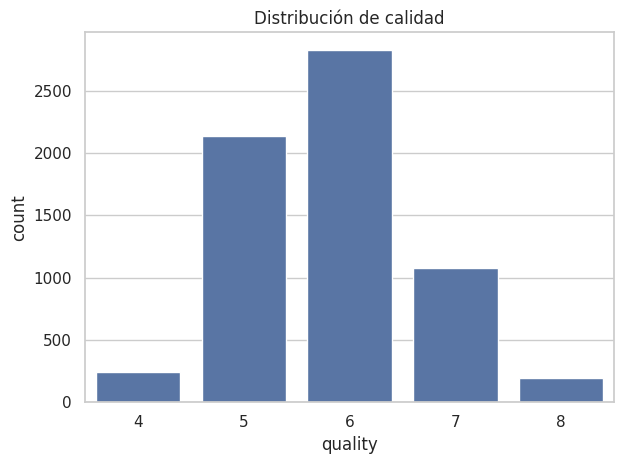

In [353]:
# Graficar la distribución de 'quality'
sns.countplot(data=ds, x='quality')
plt.title('Distribución de calidad')

# Ajustar el diseño para evitar la superposición de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Se trata de una variable categórica con 5 niveles, lo ideal sería conseguir 5 clusters, y que cada uno contenga vinos del mismo nivel de calidad. No obstante, vamos a probar otra configuración que consistirá en agrupar los niveles de calidad 4-5 y 7-8 para obtener 3 niveles.

Es como teníamos distribuidas anteriormente la variable categórica en 5 niveles, por lo que no hay que realizar ningún cambio.

De nuevo generamos un mapa de barras para identificar las variables más significativas que usaremos en la tarea de cluster.

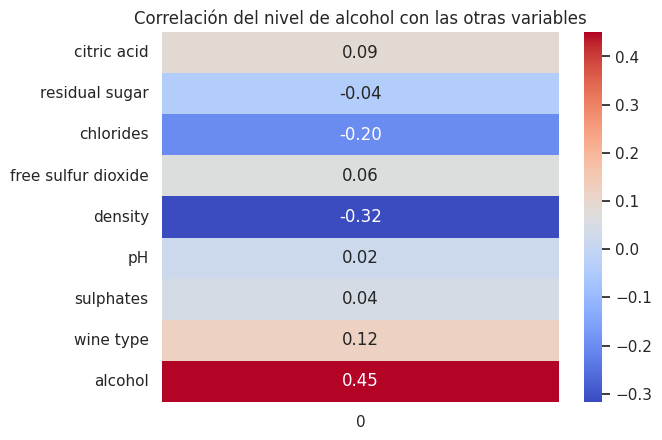

In [354]:
# Calcula la matriz de correlación
alcohol_corr = df.drop(columns=['quality']).corrwith(df['quality'])

# Generar el mapa de calor utilizando Seaborn
sns.heatmap(alcohol_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Correlación del nivel de alcohol con las otras variables')

# Mostrar el gráfico
plt.show()

El grado de alcohol y la densidad aportan la mayor información sobre la calidad del vino. Esto se expresa en las correlaciones directa para el alcohol e indirecta para la densidad. Posteriormente se encuentra `chlorides` con una correlación indirecta de -0.20.

##**PARTE 2**

###**Opción 1: CINCO CLUSTERS**

####**Opción 1A: DOS VARIABLES PREDICTORAS**

In [355]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Paso 1: Preparar los datos
X = df[['density', 'alcohol']]

# Paso 2: Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Paso 3: Realizar el clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Puedes ajustar el número de clústeres según tu criterio
kmeans.fit(X_scaled)

# Agregar las etiquetas de clúster al DataFrame original
df['Cluster'] = kmeans.labels_

df.head(1)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,quality,wine type,alcohol,Cluster
id,,,,,,,,,,,
0,0.0,1.9,0.076,11.0,0.9978,3.51,0.56,5,1,9.4,2


In [356]:
X.head(1)

,density,alcohol
id,,
0,0.9978,9.4


**Resultados**

In [357]:

# Calcular la inercia
inertia = kmeans.inertia_

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)

Añadimos los resultados a una tabla que analizaremos más adelante.

In [358]:
# Crear el DataFrame
modelos_cluster = pd.DataFrame(columns=['n_variables', 'n_clusters', 'inercia', 'silhouette_avg'])

# Añadir información del modelo anterior
modelos_cluster.loc['modelo1'] = [len(X.columns), 5, inertia, silhouette_avg]

modelos_cluster

,n_variables,n_clusters,inercia,silhouette_avg
modelo1,2.0,5.0,2086.545374,0.394803


**Representación**

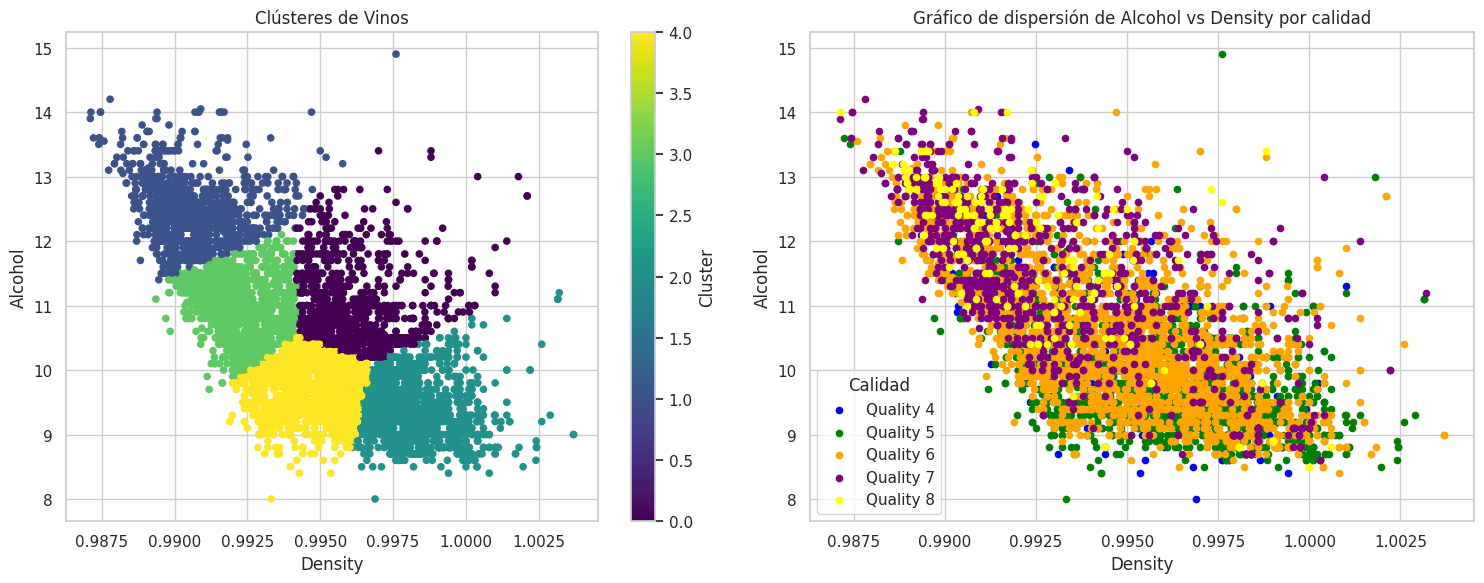

In [359]:
import matplotlib.pyplot as plt
color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4: 'purple'}

# Graficar los clústeres
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(df['density'], df['alcohol'], c=df['Cluster'], cmap='viridis', s=20)
plt.xlabel('Density')
plt.ylabel('Alcohol')
plt.title('Clústeres de Vinos')
plt.colorbar(label='Cluster')

# Graficar la dispersión por calidad
plt.subplot(1, 2, 2)

colores = {
    4: 'blue',
    5: 'green',
    6: 'orange',
    7: 'purple',
    8: 'yellow'
}

for calidad, color in colores.items():
    datos_calidad = df[df['quality'] == calidad]
    plt.scatter(datos_calidad['density'], datos_calidad['alcohol'], color=color, label=f'Quality {calidad}', s=20)

plt.xlabel('Density')
plt.ylabel('Alcohol')
plt.title('Gráfico de dispersión de Alcohol vs Density por calidad')
plt.legend(title='Calidad')
plt.grid(True)

plt.tight_layout()
plt.show()


Observamos que no hay una similitud de clústers.

####**Opción 1B: TRES VARIABLES PREDICTORAS**

Utilizamos ahora 3 variables predictoras.

In [360]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Paso 1: Preparar los datos
X = df[['density', 'alcohol','chlorides']]

# Paso 2: Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Paso 3: Realizar el clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Puedes ajustar el número de clústeres según tu criterio
kmeans.fit(X_scaled)

# Agregar las etiquetas de clúster al DataFrame original
df['Cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**Resultados**

In [361]:
# Calcular la inercia
inertia = kmeans.inertia_

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)

Añadimos a la tabla de resultados el modelo 2

In [362]:
# Añadir información del modelo anterior
modelos_cluster.loc['modelo2'] = [len(X.columns), 5, inertia, silhouette_avg]

modelos_cluster

,n_variables,n_clusters,inercia,silhouette_avg
modelo1,2.0,5.0,2086.545374,0.394803
modelo2,3.0,5.0,5028.478851,0.339732


**Representación**

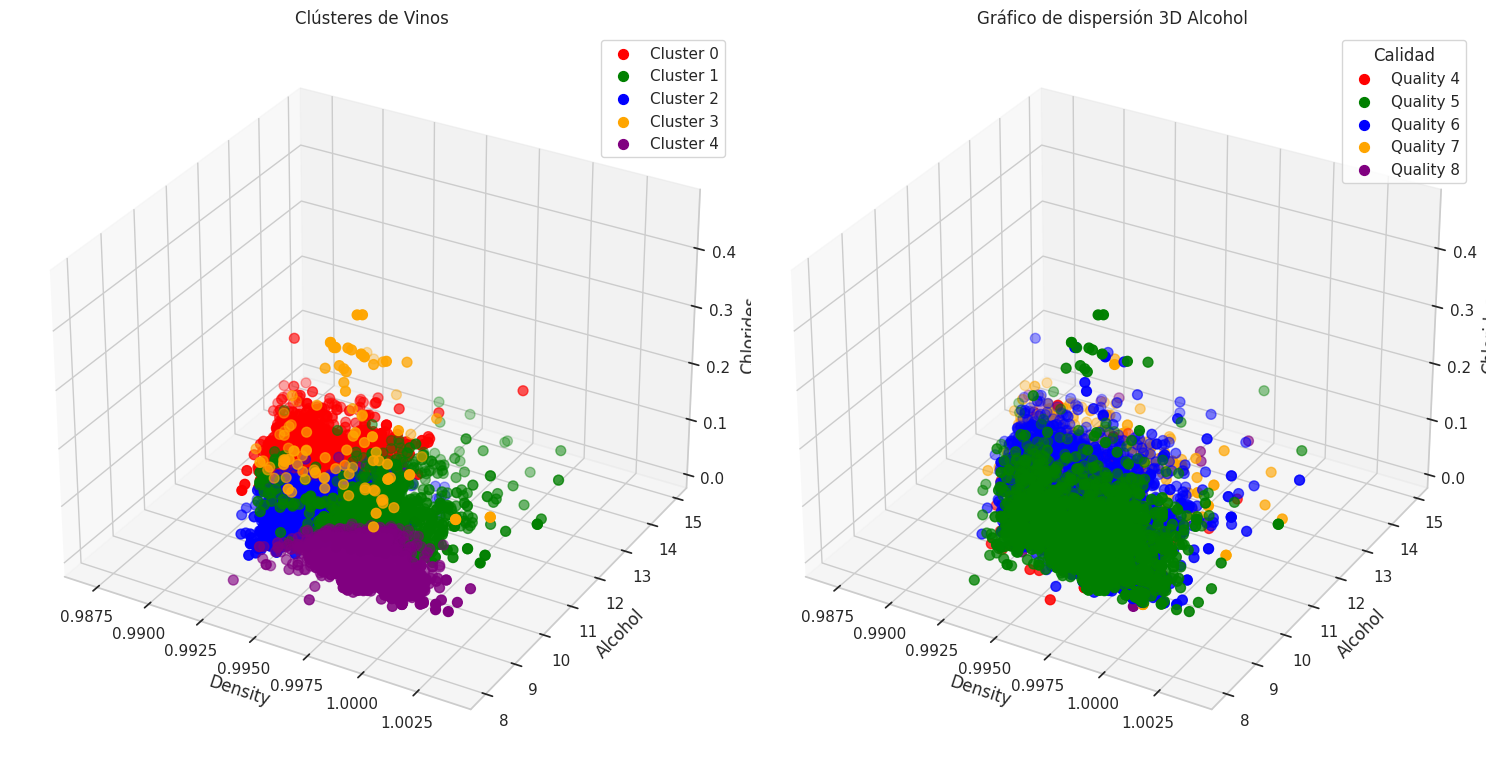

In [363]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Definir una paleta de colores
color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4: 'purple'}

# Crear la figura y los ejes para los subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': '3d'})

# Primera gráfica
# Graficar los clústeres en 3D
for cluster_label in range(kmeans.n_clusters):
    indices = df['Cluster'] == cluster_label
    axs[0].scatter(df['density'][indices], df['alcohol'][indices], df['chlorides'][indices], c=color_map[cluster_label], s=50, label=f'Cluster {cluster_label}')

axs[0].set_xlabel('Density')
axs[0].set_ylabel('Alcohol')
axs[0].set_zlabel('Chlorides')
axs[0].set_title('Clústeres de Vinos')
axs[0].legend()

# Segunda gráfica
# Graficar la dispersión por calidad en 3D
quality_levels = range(4, 9)
for calidad in quality_levels:
    indices = df['quality'] == calidad
    axs[1].scatter(df['density'][indices], df['alcohol'][indices], df['chlorides'][indices], c=color_map[calidad-4], s=50, label=f'Quality {calidad}')

axs[1].set_xlabel('Density')
axs[1].set_ylabel('Alcohol')
axs[1].set_zlabel('Chlorides')
axs[1].set_title('Gráfico de dispersión 3D Alcohol')
axs[1].legend(title='Calidad')

# Ajustar el diseño de los subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()


####**Opción 1C: N VARIABLES PREDICTORAS**

In [364]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Paso 1: Preparar los datos
X = df.drop(columns=['quality'])

# Paso 2: Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Paso 3: Realizar el clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Puedes ajustar el número de clústeres según tu criterio
kmeans.fit(X_scaled)

# Agregar las etiquetas de clúster al DataFrame original
df['Cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**Resultados**

In [365]:
# Calcular la inercia
inertia = kmeans.inertia_

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)

In [366]:
# Añadir información del modelo anterior
modelos_cluster.loc['modelo3'] = [len(X.columns), 5, inertia, silhouette_avg]

modelos_cluster

,n_variables,n_clusters,inercia,silhouette_avg
modelo1,2.0,5.0,2086.545374,0.394803
modelo2,3.0,5.0,5028.478851,0.339732
modelo3,10.0,5.0,30358.632258,0.237574


Para las 10 variables predictoras utilizadas no podemos representar los clusters ya que sería una representación en 10 dimensiones.

###**Opción 2: TRES CLUSTERS**

Veamos si mejora la clasificación para 3 clusters.

In [367]:
# Reemplazar los valores 4 con un nuevo valor 5
ds['quality'] = ds['quality'].replace({4: 5})

# Reemplazar los valores 8 con un nuevo valor 7
ds['quality'] = ds['quality'].replace({8: 7})

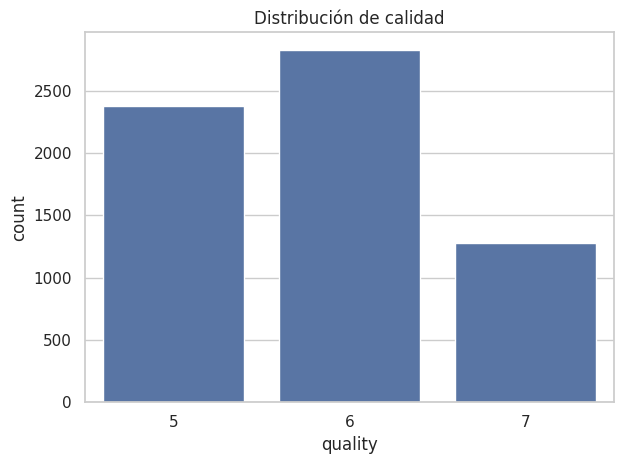

In [368]:
# Graficar la distribución de 'quality'
sns.countplot(data=ds, x='quality')
plt.title('Distribución de calidad')

# Ajustar el diseño para evitar la superposición de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

El proceso es el mismo que para 5 clusters:

- 2 variables

In [369]:
# Paso 1: Preparar los datos
X = df[['density', 'alcohol']]

# Paso 2: Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Paso 3: Realizar el clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Agregar las etiquetas de clúster al DataFrame original
df['Cluster'] = kmeans.labels_

df.head(1)

# Calcular la inercia
inertia = kmeans.inertia_

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)

# Añadir información del modelo anterior
modelos_cluster.loc['modelo4'] = [len(X.columns), 3, inertia, silhouette_avg]

modelos_cluster

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,n_variables,n_clusters,inercia,silhouette_avg
modelo1,2.0,5.0,2086.545374,0.394803
modelo2,3.0,5.0,5028.478851,0.339732
modelo3,10.0,5.0,30358.632258,0.237574
modelo4,2.0,3.0,3427.716673,0.411204


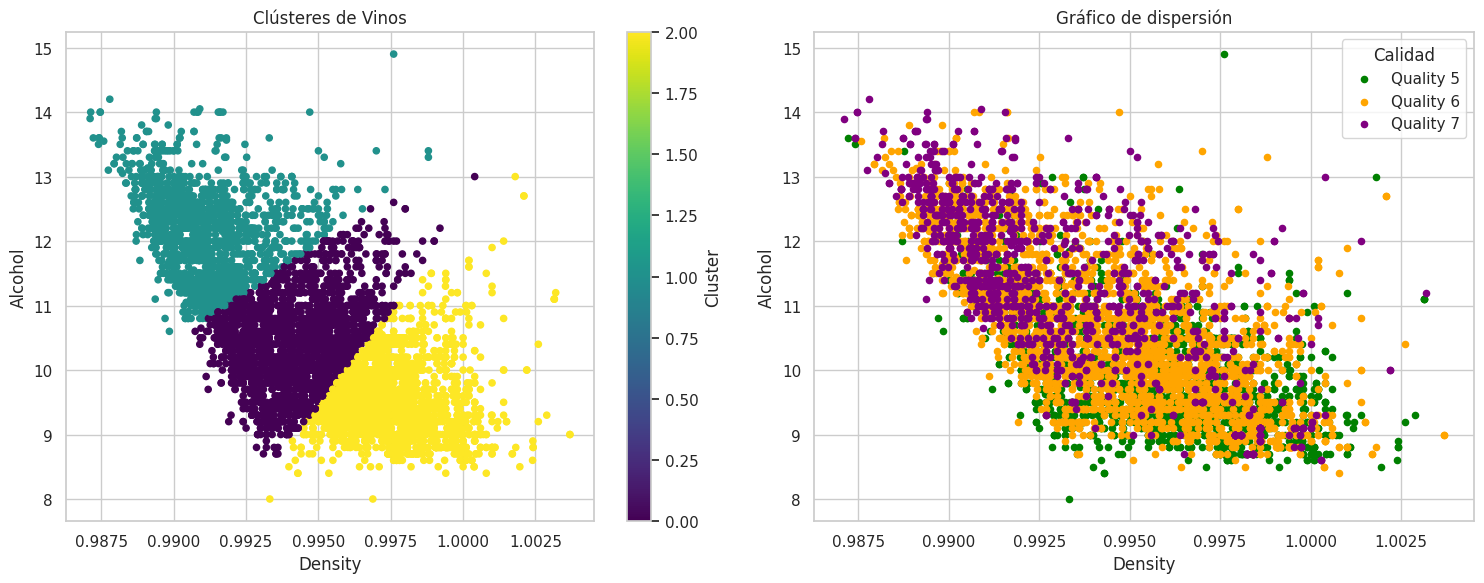

In [370]:
import matplotlib.pyplot as plt

# Graficar los clústeres
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(df['density'], df['alcohol'], c=df['Cluster'], cmap='viridis', s=20)
plt.xlabel('Density')
plt.ylabel('Alcohol')
plt.title('Clústeres de Vinos')
plt.colorbar(label='Cluster')

# Graficar la dispersión por calidad
plt.subplot(1, 2, 2)

colores = {
    5: 'green',
    6: 'orange',
    7: 'purple'
}

for calidad, color in colores.items():
    datos_calidad = df[df['quality'] == calidad]
    plt.scatter(datos_calidad['density'], datos_calidad['alcohol'], color=color, label=f'Quality {calidad}', s=20)

plt.xlabel('Density')
plt.ylabel('Alcohol')
plt.title('Gráfico de dispersión')
plt.legend(title='Calidad')
plt.grid(True)

plt.tight_layout()
plt.show()


- 3 variables:

In [371]:
# Paso 1: Preparar los datos
X = df[['density', 'alcohol','chlorides']]

# Paso 2: Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Paso 3: Realizar el clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Puedes ajustar el número de clústeres según tu criterio
kmeans.fit(X_scaled)

# Agregar las etiquetas de clúster al DataFrame original
df['Cluster'] = kmeans.labels_

# Calcular la inercia
inertia = kmeans.inertia_

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)

# Añadir información del modelo anterior
modelos_cluster.loc['modelo5'] = [len(X.columns), 3, inertia, silhouette_avg]

modelos_cluster

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,n_variables,n_clusters,inercia,silhouette_avg
modelo1,2.0,5.0,2086.545374,0.394803
modelo2,3.0,5.0,5028.478851,0.339732
modelo3,10.0,5.0,30358.632258,0.237574
modelo4,2.0,3.0,3427.716673,0.411204
modelo5,3.0,3.0,7868.984419,0.451944


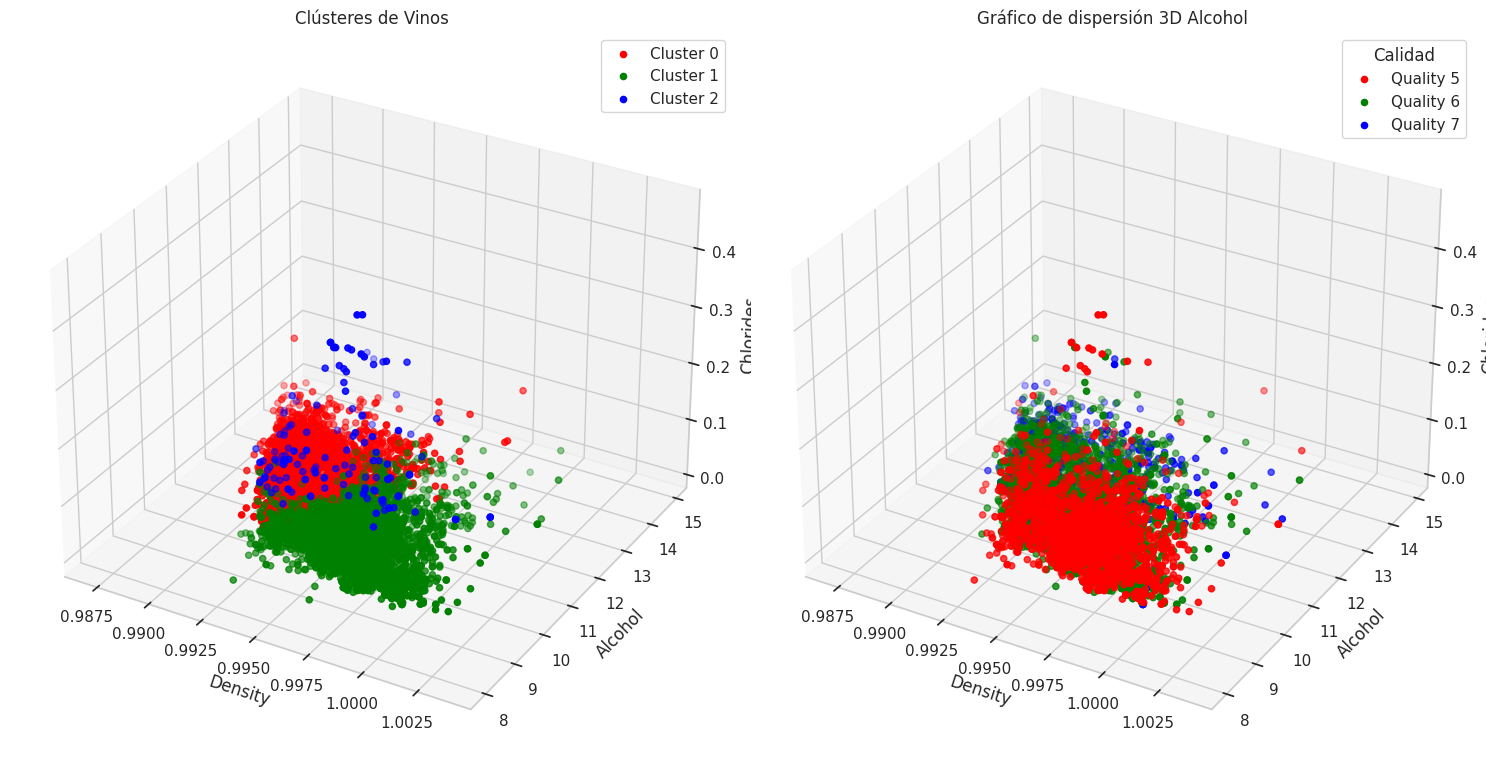

In [372]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Definir una paleta de colores
color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4: 'purple'}

# Crear la figura y los ejes para los subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': '3d'})

# Primera gráfica
# Graficar los clústeres en 3D
for cluster_label in range(kmeans.n_clusters):
    indices = df['Cluster'] == cluster_label
    axs[0].scatter(df['density'][indices], df['alcohol'][indices], df['chlorides'][indices], c=color_map[cluster_label], s=20, label=f'Cluster {cluster_label}')

axs[0].set_xlabel('Density')
axs[0].set_ylabel('Alcohol')
axs[0].set_zlabel('Chlorides')
axs[0].set_title('Clústeres de Vinos')
axs[0].legend()

# Segunda gráfica
# Graficar la dispersión por calidad en 3D
quality_levels = range(5, 8)
for calidad in quality_levels:
    indices = df['quality'] == calidad
    axs[1].scatter(df['density'][indices], df['alcohol'][indices], df['chlorides'][indices], c=color_map[calidad-5], s=20, label=f'Quality {calidad}')

axs[1].set_xlabel('Density')
axs[1].set_ylabel('Alcohol')
axs[1].set_zlabel('Chlorides')
axs[1].set_title('Gráfico de dispersión 3D Alcohol')
axs[1].legend(title='Calidad')

# Ajustar el diseño de los subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()


- 10 variables

In [373]:
# Paso 1: Preparar los datos
X = df.drop(columns=['quality'])

# Paso 2: Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Paso 3: Realizar el clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Agregar las etiquetas de clúster al DataFrame original
df['Cluster'] = kmeans.labels_

# Calcular la inercia
inertia = kmeans.inertia_

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)

# Añadir información del modelo anterior
modelos_cluster.loc['modelo6'] = [len(X.columns), 3, inertia, silhouette_avg]

modelos_cluster

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,n_variables,n_clusters,inercia,silhouette_avg
modelo1,2.0,5.0,2086.545374,0.394803
modelo2,3.0,5.0,5028.478851,0.339732
modelo3,10.0,5.0,30358.632258,0.237574
modelo4,2.0,3.0,3427.716673,0.411204
modelo5,3.0,3.0,7868.984419,0.451944
modelo6,10.0,3.0,36809.485318,0.307414


##**PARTE 3**

Analiza los clústeres obtenidos para el mejor valor de k y responde a las siguientes preguntas:
• ¿Existe algún tipo de similitud entre los grupos obtenidos y los valores de la variable quality del
dataset? (0.5 puntos).
• ¿Cómo se diferencian los clústeres entre sí? (0.5 puntos).
En necesario justificar las respuestas mediante la utilización de datos empíricos

Analizamos la tabla de resultados

In [374]:
modelos_cluster

,n_variables,n_clusters,inercia,silhouette_avg
modelo1,2.0,5.0,2086.545374,0.394803
modelo2,3.0,5.0,5028.478851,0.339732
modelo3,10.0,5.0,30358.632258,0.237574
modelo4,2.0,3.0,3427.716673,0.411204
modelo5,3.0,3.0,7868.984419,0.451944
modelo6,10.0,3.0,36809.485318,0.307414


Para determinar cuál es el mejor modelo de clusterización, se pueden considerar diferentes métricas como la inercia y el coeficiente de silueta.

La inercia es una medida de la compacidad de los clusters, donde valores más bajos indican que los puntos dentro de cada cluster están más cercanos entre sí. Por otro lado, el coeficiente de silueta mide qué tan similar es un objeto a su propio cluster en comparación con otros clusters. Valores más altos (cercanos a 1) indican una buena separación entre clusters.

Dado que tanto la inercia como el coeficiente de silueta son importantes, podemos evaluar los modelos considerando ambos. Si bien no hay un único "mejor" modelo, se puede seleccionar aquel que tenga un buen equilibrio entre inercia baja y coeficiente de silueta alto.

Dando peso a ambas métricas, el modelo que parece destacarse es el modelo5 con 3 variables y 3 clusters, ya que tiene una inercia relativamente baja (7868.98) y un coeficiente de silueta alto (0.4519). Esto sugiere que los clusters son compactos y bien separados entre sí.

Conclusiones:

## **EJERCICIO 4**

### **Enunciado**

La empresa productora de vinos desea mejorar el proceso de producción de sus vinos con el objetivo de
mejorar las futuras producciones.  
Para ello han pensado en utilizar un algoritmo de agrupamiento jerárquico para segmentar los diferentes vinos
en base a sus componentes, calidad y nivel de alcohol.

1) Dado el mejor valor de k del apartado anterior selecciona los 10 ejemplos más representativos de cada
clúster para generar un nuevo dataset y aplicar agrupamiento jerárquico y responder a las siguientes
preguntas:

•¿Cuál ha sido tu criterio para seleccionar los ejemplos más representativos de cada clúster? (0,5
puntos).  

2) Seleccionar un algoritmo de agrupamiento jerárquico y generar los diferentes clústeres en base a los
atributos seleccionados (0.75 puntos).  

3) Generar y analizar el dendrograma resultante del proceso de agrupamiento. (0,75 puntos)

### **PARTE 1**

Para el "modelo5" cuyo k=3, elegimos los 10 ejemplos más representativos de cada cluster. Para ello, tomaremos las 10 observaciones más próximas a los centros de cada cluster. Utilizamos la distancia euclídea para calcular dichas distancias.

In [375]:
# Seleccionar los 10 ejemplos más representativos de cada clúster
representative_examples = pd.DataFrame(columns=df.columns)
for cluster_label in range(3):
    cluster_data = df[df['Cluster'] == cluster_label]
    if len(cluster_data) >= 10:  # Verificar si hay al menos 10 ejemplos en el clúster
        # Filtrar los datos normalizados para este clúster
        cluster_X_scaled = X_scaled[df['Cluster'] == cluster_label]
        # Calcular la distancia de cada ejemplo al centroide del clúster
        distances = np.linalg.norm(cluster_X_scaled - kmeans.cluster_centers_[cluster_label], axis=1)
        # Agregar la columna de distancias al DataFrame cluster_data
        cluster_data['distance_to_centroid'] = distances
        # Ordenar los ejemplos por distancia al centroide y seleccionar los primeros 10
        cluster_representatives = cluster_data.sort_values(by='distance_to_centroid').head(10)
    else:
        # Si hay menos de 10 ejemplos en el clúster, seleccionar todos los ejemplos
        cluster_representatives = cluster_data
    representative_examples = pd.concat([representative_examples, cluster_representatives])

<ipython-input-375-4beecf93b97b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['distance_to_centroid'] = distances
<ipython-input-375-4beecf93b97b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['distance_to_centroid'] = distances
<ipython-input-375-4beecf93b97b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Imprimimos los 10 ejemplos más representativos de cada clúster

In [378]:
for cluster_label in range(3):
    cluster_examples = representative_examples[representative_examples['Cluster'] == cluster_label].head(10)
    print(f"Ejemplos más representativos del clúster {cluster_label}:")
    print(cluster_examples)
    print("\n")

Ejemplos más representativos del clúster 0:
      citric acid  residual sugar  chlorides  free sulfur dioxide  density  \
1283         0.28             2.7      0.096                 17.0  0.99734   
1163         0.24             1.7      0.078                 10.0  0.99692   
1164         0.24             1.7      0.078                 10.0  0.99692   
981          0.26             1.9      0.079                 13.0  0.99712   
1308         0.32             2.5      0.088                 22.0  0.99790   
1306         0.32             2.5      0.088                 22.0  0.99790   
1073         0.33             2.7      0.088                 16.0  0.99720   
100          0.30             2.1      0.084                 11.0  0.99720   
1320         0.34             2.6      0.094                 12.0  0.99796   
490          0.27             2.8      0.078                 24.0  0.99840   

        pH  sulphates quality wine type  alcohol Cluster  distance_to_centroid  
1283  3.26      

Estos ejemplos nos proporcionan una visión de las características predominantes dentro de cada clúster.

Por ejemplo, en el clúster 0, se observa que los vinos tienen niveles moderados de ácido cítrico, azúcar residual y cloruros, con una variedad en los niveles de alcohol.

En contraste, el clúster 1 muestra vinos con niveles más bajos de ácido cítrico y azúcar residual, pero con niveles más altos de cloruros y sulfatos.

Por último, el clúster 2 exhibe vinos con niveles variables de ácido cítrico y azúcar residual, pero generalmente más altos que en los otros clústeres, con niveles medios de cloruros y sulfatos.

### **PARTE 2**

Lo primero que hacemos es importar las herramientas necesarias de la biblioteca scikit-learn, incluyendo la clase **AgglomerativeClustering** para el agrupamiento jerárquico y la función **silhouette_score** para evaluar la calidad de los clústeres.

Luego, definimos una lista de métodos de enlace que queremos probar. A continuación, iteramos sobre cada método de enlace, inicializamos y ajustamos el modelo de agrupamiento jerárquico a los datos, y calculamos el coeficiente de silueta para cada método.

Finalmente, agregamos las etiquetas de clústeres al DataFrame para identificar a qué clúster pertenece cada muestra según el método de enlace utilizado.

In [379]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Lista# Lista de enlaces
linkages = ['complete', 'single', 'average', 'ward']

# Variafrom sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Lista de enlaces
linkages = ['complete', 'single', 'average', 'ward']

# Variables para almacenar los resultados
silhouette_scores = {}

# Bucle para aplicar el agrupamiento jerárquico con diferentes enlaces
for linkage in linkages:
    # Inicializar el modelo de agrupamiento jerárquico
    agg_cluster = AgglomerativeClustering(n_clusters=5, linkage=linkage)

    # Ajustar el modelo a los datos normalizados
    agg_cluster.fit(representative_examples.drop(columns=['Cluster', 'distance_to_centroid']))

    # Calcular el coeficiente de silueta
    silhouette_scores[linkage] = silhouette_score(representative_examples.drop(columns=['Cluster', 'distance_to_centroid']), agg_cluster.labels_)

    # Agregar las etiquetas de clústeres al DataFrame
    representative_examples[f'Hierarchical_Cluster_{linkage.capitalize()}'] = agg_cluster.labels_

Imprimimos los coeficientes de silueta para cada enlace.

In [380]:
print("Coeficiente de silueta:")
for linkage, silhouette in silhouette_scores.items():
    print(f"Método de enlace {linkage.capitalize()}: {silhouette}")

Coeficiente de silueta:
Método de enlace Complete: 0.576038378422094
Método de enlace Single: 0.5480233481309781
Método de enlace Average: 0.5949793375053382
Método de enlace Ward: 0.6009026465014072


Estos coeficientes de silueta proporcionan una visión sobre la calidad de los agrupamientos obtenidos. Cuanto más cerca esté el valor del coeficiente de silueta de 1, mejor será la calidad del agrupamiento, indicando una buena cohesión dentro de los clústeres y una clara separación entre ellos.

Según los coeficientes de silueta proporcionados:

- El método de enlace completo (Complete) muestra un coeficiente de silueta de 0.576, indicando una calidad razonable en la cohesión y separación de los clústeres.
- El método de enlace único (Single) le sigue con un coeficiente de silueta de 0.548, también mostrando una calidad aceptable en el agrupamiento.
- El método de enlace promedio (Average) tiene el coeficiente de silueta más alto, con un valor de 0.595, lo que sugiere una mejor cohesión y separación entre los clústeres.
- El método de enlace de Ward muestra un coeficiente de silueta de 0.601, siendo ligeramente superior al promedio y demostrando una buena calidad en la formación de clústeres.

Esto sugiere que el método de enlace de Ward podría haber producido clústeres ligeramente más cohesivos y mejor separados en comparación con los otros métodos, aunque el método de enlace promedio también muestra una calidad significativa en el agrupamiento.

Distribución de vinos en cada clúster:
Hierarchical_Cluster_Complete
0    7
1    5
2    8
3    5
4    5
Name: count, dtype: int64


<ipython-input-381-0c6c1755934f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=representative_examples, x=f'Hierarchical_Cluster_{linkage.capitalize()}', palette='viridis')


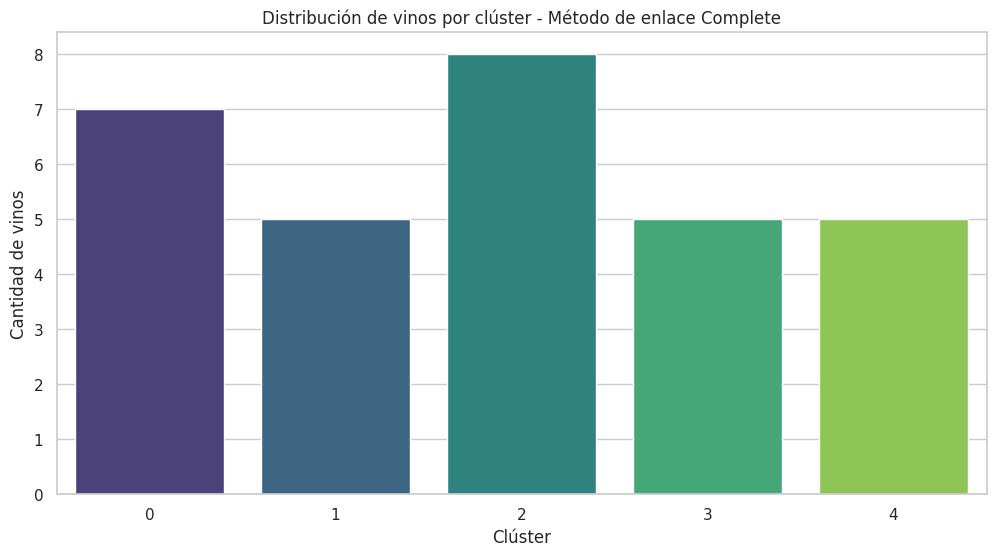

Distribución de vinos en cada clúster:
Hierarchical_Cluster_Single
0    8
1    8
2    7
3    5
4    2
Name: count, dtype: int64


<ipython-input-381-0c6c1755934f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=representative_examples, x=f'Hierarchical_Cluster_{linkage.capitalize()}', palette='viridis')


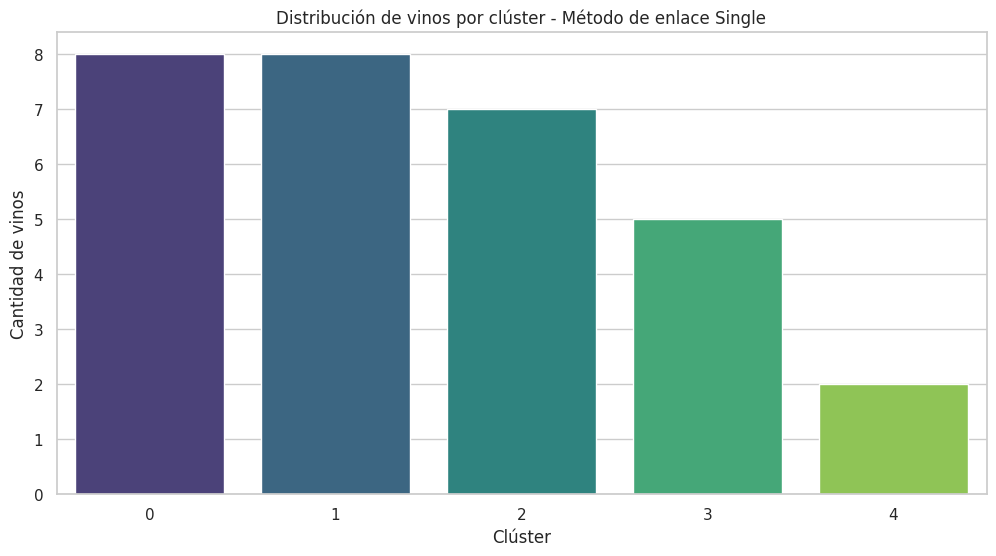

Distribución de vinos en cada clúster:
Hierarchical_Cluster_Average
0    8
1    7
2    5
3    8
4    2
Name: count, dtype: int64


<ipython-input-381-0c6c1755934f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=representative_examples, x=f'Hierarchical_Cluster_{linkage.capitalize()}', palette='viridis')


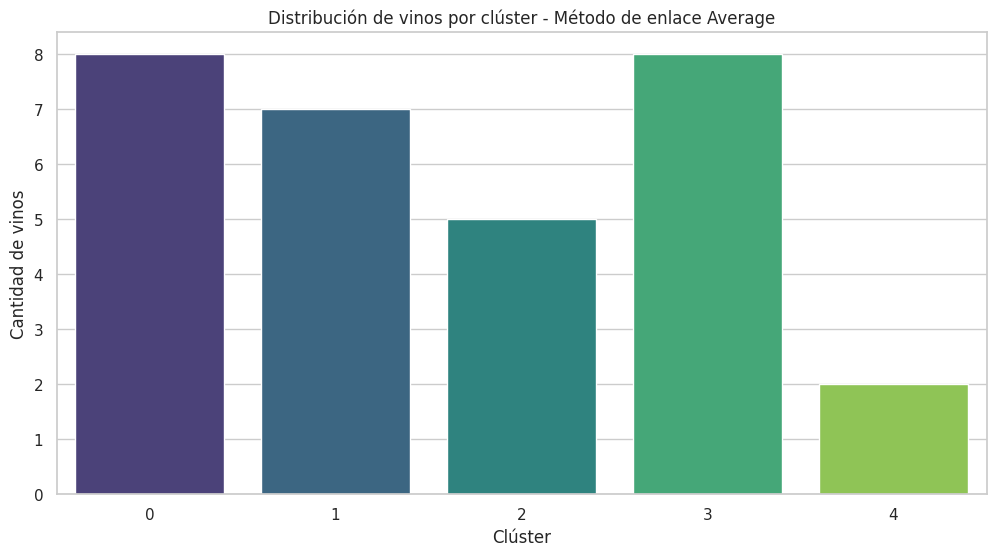

Distribución de vinos en cada clúster:
Hierarchical_Cluster_Ward
0    8
1    7
2    5
3    5
4    5
Name: count, dtype: int64


<ipython-input-381-0c6c1755934f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=representative_examples, x=f'Hierarchical_Cluster_{linkage.capitalize()}', palette='viridis')


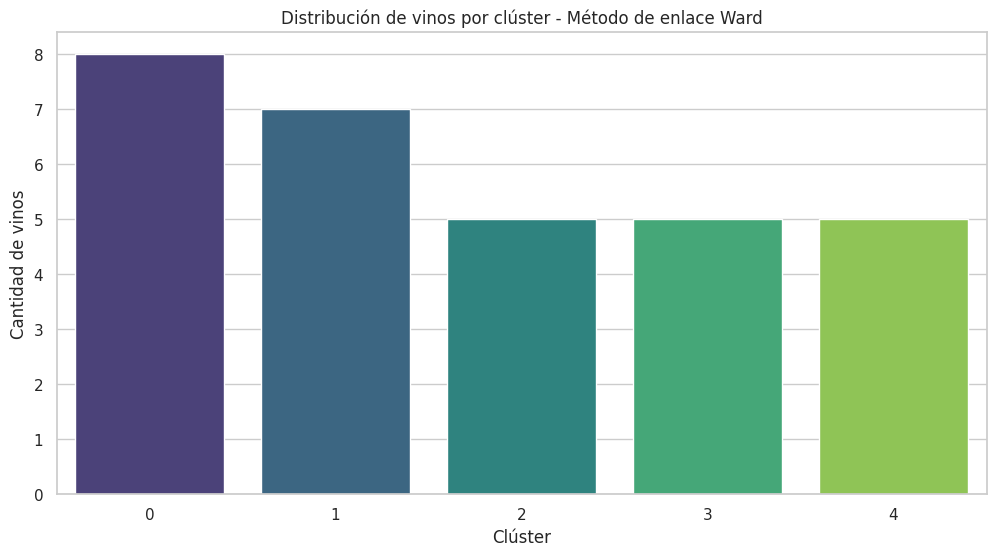

In [381]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bucle para generar la distribución de vinos en cada clúster
for linkage in linkages:
    # Ver la distribución de los vinos en cada clúster
    cluster_distribution = representative_examples[f'Hierarchical_Cluster_{linkage.capitalize()}'].value_counts().sort_index()
    print("Distribución de vinos en cada clúster:")
    print(cluster_distribution)

    plt.figure(figsize=(12, 6))
    sns.countplot(data=representative_examples, x=f'Hierarchical_Cluster_{linkage.capitalize()}', palette='viridis')
    plt.title(f'Distribución de vinos por clúster - Método de enlace {linkage.capitalize()}')
    plt.xlabel('Clúster')
    plt.ylabel('Cantidad de vinos')
    plt.show()

Basándonos en la distribución de vinos en los diferentes métodos de agrupamiento jerárquico, podemos realizar las siguientes observaciones:

**Enlace completo (Complete):** Este método produce clústeres con una variedad de distribución de vinos. Algunos clústeres contienen un número significativo de vinos (por ejemplo, clúster 0 y clúster 1), mientras que otros tienen un número mucho menor de vinos (por ejemplo, clúster 2, clúster 3 y clúster 4).

**Enlace único (Single):** Este método produce un clúster dominante (clúster 0) que contiene la mayoría de los vinos, mientras que los otros clústeres tienen un número mucho menor de vinos. Esto sugiere que el método de enlace único podría no ser óptimo para este conjunto de datos, ya que agrupa la mayoría de los vinos en un solo clúster.

**Enlace promedio (Average):** Similar al enlace completo, este método produce clústeres con una distribución variada de vinos. Sin embargo, la distribución de vinos en cada clúster parece ser más equilibrada en comparación con el enlace completo.

**Enlace de Ward (Ward):** Este método produce clústeres con una distribución más equilibrada de vinos en comparación con los otros métodos. Cada clúster tiene un número similar de vinos, lo que sugiere una distribución más uniforme.

Basándonos en estas observaciones y la distribución de vinos en cada clúster:

- Para el enlace completo, los clústeres tienen una distribución variada y desigual de vinos.
- El enlace único tiende a agrupar la mayoría de los vinos en un solo clúster.
- El enlace promedio muestra una distribución más equilibrada, pero todavía tiene un clúster dominante.
- El enlace de Ward produce clústeres con una distribución más uniforme de vinos.

Considerando estos resultados, podríamos concluir que el método de enlace de Ward parece ser el más adecuado para este conjunto de datos, ya que produce clústeres más equilibrados en términos de distribución de vinos y estadísticas resumidas coherentes en cada clúster.

In [382]:
# Bucle para ver las estadísticas resumidas
for linkage in linkages:
    print(f"\nMétodo de enlace: {linkage.capitalize()}")

    # Seleccionar solo las columnas numéricas para calcular las estadísticas resumidas
    numeric_columns = representative_examples.select_dtypes(include=['float64', 'int64'])

    # Estadísticas resumidas de los atributos numéricos en cada clúster
    cluster_stats = numeric_columns.groupby(representative_examples[f'Hierarchical_Cluster_{linkage.capitalize()}']).mean()
    print("\nEstadísticas resumidas de los atributos en cada clúster:")
    print(cluster_stats)


Método de enlace: Complete

Estadísticas resumidas de los atributos en cada clúster:
                               citric acid  residual sugar  chlorides  \
Hierarchical_Cluster_Complete                                           
0                                 0.284286            2.20   0.085286   
1                                 0.312000            2.64   0.064600   
2                                 0.328750            4.10   0.038500   
3                                 0.342000            9.20   0.048800   
4                                 0.346000            7.74   0.050400   

                               free sulfur dioxide   density        pH  \
Hierarchical_Cluster_Complete                                            
0                                        12.714286  0.997237  3.294286   
1                                        24.000000  0.995346  3.248000   
2                                        33.750000  0.991812  3.210000   
3                               

Veamos las estadísticas resumidas de los atributos para cada método de enlace:

**Método de enlace Complete:**

- Los clústeres parecen diferenciarse principalmente en el contenido de azúcar residual y dióxido de azufre total.
- Algunos clústeres tienen valores extremos en ciertos atributos, como el clúster 3, que tiene un contenido de azúcar residual muy alto.
- La interpretabilidad puede ser un desafío debido a la variabilidad en las características de los vinos dentro de cada clúster.

**Método de enlace Single:**

- Los clústeres tienen una distribución más equilibrada de vinos.
- Las diferencias entre clústeres parecen ser menos pronunciadas que en otros métodos de enlace.
- La interpretabilidad puede ser más fácil debido a la consistencia en las características de los vinos dentro de cada clúster.

**Método de enlace Average:**

- Los clústeres muestran diferencias en varios atributos, incluyendo acidez fija, acidez volátil y contenido de alcohol.
- Algunos clústeres tienen características muy distintas, como el clúster 1, que tiene una alta acidez volátil y baja acidez fija en comparación con otros clústeres.
- La interpretabilidad puede ser moderada, ya que hay una mezcla de clústeres con características claramente distintas y otros con diferencias más sutiles.

**Método de enlace Ward:**

- Los clústeres muestran diferencias en múltiples atributos, incluyendo acidez volátil, densidad y contenido de alcohol.
- Los clústeres parecen ser coherentes en términos de características de los vinos, con diferencias significativas entre ellos.
- La interpretabilidad puede ser alta debido a la consistencia en las características de los vinos dentro de cada clúster y las diferencias claras entre clústeres.

Dado que el método de enlace Ward muestra una cohesión alta en los atributos de los vinos en cada clúster y proporciona una distribución más equilibrada de vinos en comparación con los otros métodos, podríamos concluir que el método de enlace de Ward es el más adecuado para este conjunto de datos.

### **PARTE 3**

El proceso inicia calculando las distancias entre todos los puntos de datos mediante la matriz de distancias. Posteriormente, se emplea el método de enlace seleccionado, como el método de enlace de Ward, para agrupar los puntos en clústeres jerárquicos. Este método calcula la distancia entre los clústeres combinados de manera que se minimice la varianza dentro de cada uno. Una vez calculado el enlace, se visualiza el dendrograma resultante. Este gráfico muestra la estructura jerárquica de los clústeres, donde la distancia en el eje vertical representa la disimilitud entre los clústeres o puntos individuales. Tal representación gráfica facilita la comprensión de cómo se agrupan los datos y ayuda en la interpretación de la estructura de los clústeres, así como en la determinación del número óptimo de clústeres para el conjunto de datos.

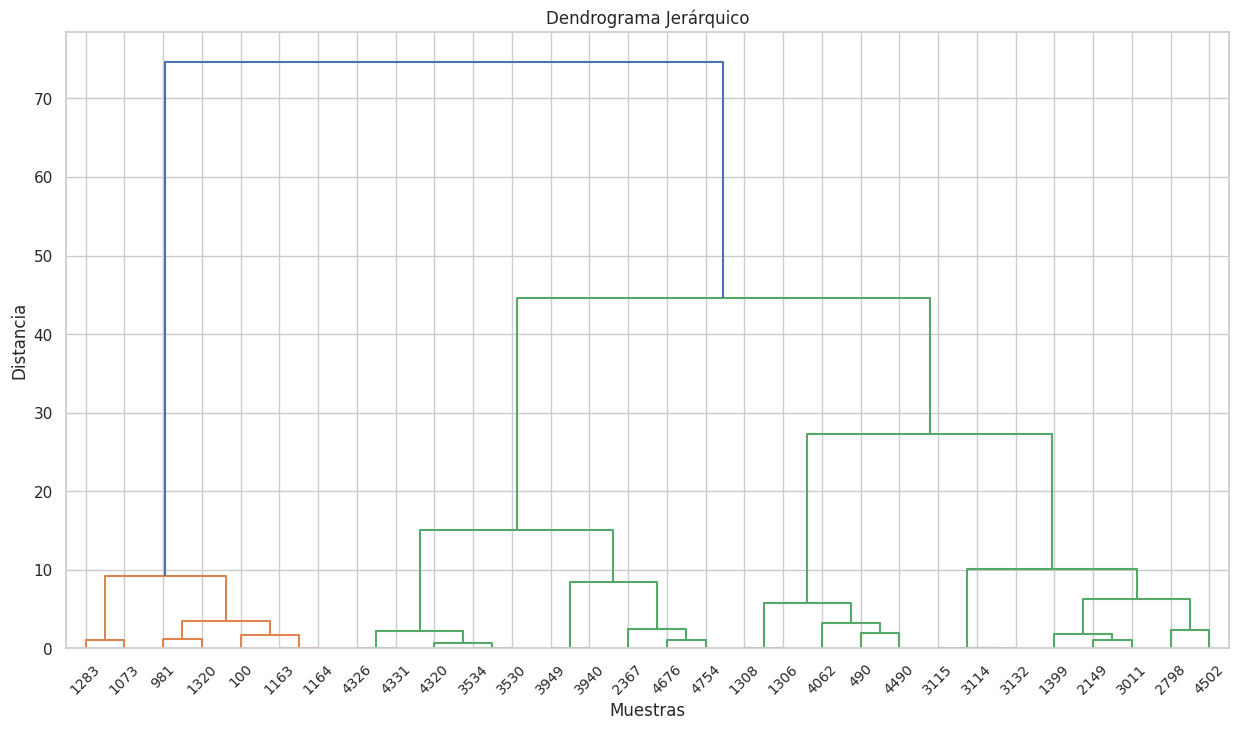

In [385]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Obtener los identificadores de las muestras
sample_ids = representative_examples.index.tolist()

# Calcular la matriz de enlace utilizando el método de enlace 'ward'
Z = linkage(representative_examples.drop(columns=['Cluster', 'distance_to_centroid']), method='ward')

# Generar el dendrograma
plt.figure(figsize=(15, 8))
dendrogram(Z, labels=sample_ids)
plt.title('Dendrograma Jerárquico')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

El dendrograma jerárquico consta de tres componentes principales: distancia, dendrograma jerárquico y muestras. La distancia varía de 0 a 70, y el dendrograma jerárquico tiene valores de 0 a 4331. Las muestras tienen valores que van desde 1306 hasta 4754.

